# Carga de Datos

## Carga de librerias

In [520]:
from wget import download
from os import path
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal

## Descarga del dataset

In [521]:
if not path.exists("winequality_BE.csv"):
  download("https://drive.usercontent.google.com/download?id=189YJW1xLicejwf38HGch5Hr61bdnU0Hp&export=download&authuser=0&confirm=t&uuid=75168cf8-4582-43cd-a4b3-844c6366a42e&at=AO7h07dTuRLsrGPMEWeQKxIgplSw:1725904846539")
else:
  print("El archivo ya existe")

El archivo ya existe


### Abrimos y leemos el DataSet con las herramientas que nos aporta la biblioteca Pandas.
La funcion de pandas ``read_csv`` nos permite poder leer el archivo directamente desde el formato CSV. En nuestro caso el archivo que contenia la informacion de nuestro dataset utilizaba el punto y coma ``;`` como separador de columnas, lo cual no es el standard de este formato, ya que generalmente las columnas vienen divididas por solo una coma ``,``; el ``read_csv`` de pandas te brinda la posibilidad de especificarle el caracter por el cual estan separadas las columnas utilizando ``delimiter`` el cual se pasa como parametro en la funcion.

In [522]:
raw_dataSet = pd.read_csv("winequality_BE.csv", delimiter=";")


### Copiamos el DataFrame para no modificar y/o perder el original
En Python las variables se comportan un poco distintos a otros lenguajes, estas se pasan por valor o por referencia segun el tipo de variable. En este caso Python pasa por referencia los DataSets para optimizar el uso de memoria, por esto debemos utilizar ``copy()`` de Pandas para tener una copia del DataSet y salvar el original.

In [523]:
dataSetCurado = raw_dataSet.copy()

### Checkeamos el DataSet para ver los tipos de variables que tenemos
El metodo ``info()`` nos da informacion como el tipo de variable de las columnas, el total de ellas, el tamaño del DataFrame, etc.

In [524]:
dataSetCurado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3232 non-null   object 
 1   fixed acidity         3232 non-null   float64
 2   volatile acidity      3232 non-null   float64
 3   citric acid           3232 non-null   float64
 4   residual sugar        3232 non-null   float64
 5   chlorides             3232 non-null   float64
 6   free sulfur dioxide   3232 non-null   float64
 7   total sulfur dioxide  3232 non-null   float64
 8   density               3232 non-null   float64
 9   pH                    3232 non-null   float64
 10  sulphates             3232 non-null   float64
 11  alcohol               3232 non-null   object 
 12  quality               3232 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 328.4+ KB


# Limpieza de datos

Vemos que la variable ``Alcohol`` es de tipo ``Object``, esto es un problema ya que esta variable contiene el nivel alcohólico del vino, medido en porcentaje de volumen (% vol)

## Analisis de la columna Alcohol
Buscamos dentro de la columna ``Alcohol`` los valores que no son numericos. Al intentar Utilizando el metodo ``astype('float64')`` nos da el siguiente error <span style="color:red"> ValueError: could not convert string to float: '100.333.333.333.333'</span>. Este error nos revela que existen valores que superan la cantidad de caracteres necesarios.

In [525]:
indx = dataSetCurado["alcohol"][dataSetCurado["alcohol"].str.len() > 5].index
dataSetCurado.loc[indx]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2992,Merlot,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,100.333.333.333.333,6
2995,Merlot,11.6,0.475,0.40,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,100.333.333.333.333,6
3072,Merlot,7.3,0.670,0.02,2.2,0.072,31.0,92.0,0.99566,3.32,0.68,110.666.666.666.667,6
3074,Merlot,7.4,0.785,0.19,5.2,0.094,19.0,98.0,0.99713,3.16,0.52,956.666.666.666.667,6
3108,Merlot,5.3,0.470,0.11,2.2,0.048,16.0,89.0,0.99182,3.54,0.88,135.666.666.666.667,7
3147,Merlot,6.9,0.840,0.21,4.1,0.074,16.0,65.0,0.99842,3.53,0.72,923.333.333.333.333,6


Podemos ver que hay datos mal cargados, estos son los causantes de que esta columna no sea de tipo ``Float``.

### Eliminamos los valores mal cargados 

Esta es una función anónima que realiza lo siguiente:

- **Parámetro `x`**: Cada valor en la columna "alcohol" se pasa como entrada a la función.
- **Condición `len(x) > 5`**: Verifica si la longitud del valor es mayor a 5.
- **Acción**:
  - Si la longitud del valor es mayor a 5, devuelve `np.nan` (un valor `NaN` que representa datos faltantes en Pandas).
  - Si la longitud es menor o igual a 5, simplemente devuelve el valor original de `x`.

In [526]:
dataSetCurado['alcohol'] = dataSetCurado['alcohol'].apply(lambda x: np.nan if len(x) > 5 else x)

dataSetCurado = dataSetCurado.dropna()

dataSetCurado

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Viogner,7.4,0.190,0.49,6.7,0.037,15.0,110.0,0.99380,3.20,0.38,11,7
1,Viogner,8.3,0.250,0.49,16.8,0.048,50.0,228.0,10.00100,3.03,0.52,9.2,6
2,Viogner,7.5,0.140,0.74,1.6,0.035,21.0,126.0,0.99330,3.26,0.45,10.2,6
3,Viogner,7.8,0.490,0.49,7.0,0.043,29.0,149.0,0.99520,3.21,0.33,10,5
4,Viogner,8.1,0.120,0.49,1.2,0.042,43.0,160.0,0.99340,3.13,0.48,9.7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,Merlot,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
3228,Merlot,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
3229,Merlot,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11,6
3230,Merlot,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Cambiamos el tipo de variable a Float 





Mediante el metodo `astype` de pandas convertimos todos los valores de la columna alcohol al tipo `float64`.

In [527]:
dataSetCurado['alcohol'] = dataSetCurado['alcohol'].astype('float64')
dataSetCurado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3226 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3226 non-null   object 
 1   fixed acidity         3226 non-null   float64
 2   volatile acidity      3226 non-null   float64
 3   citric acid           3226 non-null   float64
 4   residual sugar        3226 non-null   float64
 5   chlorides             3226 non-null   float64
 6   free sulfur dioxide   3226 non-null   float64
 7   total sulfur dioxide  3226 non-null   float64
 8   density               3226 non-null   float64
 9   pH                    3226 non-null   float64
 10  sulphates             3226 non-null   float64
 11  alcohol               3226 non-null   float64
 12  quality               3226 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 352.8+ KB


### Cambiamos el tipo de variables object a string

In [528]:
dataSetCurado['type'] = dataSetCurado['type'].astype('string')
dataSetCurado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3226 entries, 0 to 3231
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  3226 non-null   string 
 1   fixed acidity         3226 non-null   float64
 2   volatile acidity      3226 non-null   float64
 3   citric acid           3226 non-null   float64
 4   residual sugar        3226 non-null   float64
 5   chlorides             3226 non-null   float64
 6   free sulfur dioxide   3226 non-null   float64
 7   total sulfur dioxide  3226 non-null   float64
 8   density               3226 non-null   float64
 9   pH                    3226 non-null   float64
 10  sulphates             3226 non-null   float64
 11  alcohol               3226 non-null   float64
 12  quality               3226 non-null   int64  
dtypes: float64(11), int64(1), string(1)
memory usage: 352.8 KB


## Analisis de filas duplicadas

Utilizamos el metodo duplicated() y sum() de Pandas para ver la cantidad de filas duplicadas del DataSet

In [529]:
dataSetCurado.duplicated().sum()

np.int64(572)

### Eliminamos las filas duplicadas

Tenemos 573 filas duplicadas, estas filas no suman informacion, por lo tanto utilizamos ``drop_duplicates(keep='first')`` para eliminar dichas filas. Con ``keep='first'`` le indicamos que queremos guardar la primer tupla.

In [530]:
dataSetCurado = dataSetCurado.drop_duplicates(keep='first')
dataSetCurado = dataSetCurado.reset_index(drop=True)
dataSetCurado

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Viogner,7.4,0.190,0.49,6.7,0.037,15.0,110.0,0.99380,3.20,0.38,11.0,7
1,Viogner,8.3,0.250,0.49,16.8,0.048,50.0,228.0,10.00100,3.03,0.52,9.2,6
2,Viogner,7.5,0.140,0.74,1.6,0.035,21.0,126.0,0.99330,3.26,0.45,10.2,6
3,Viogner,7.8,0.490,0.49,7.0,0.043,29.0,149.0,0.99520,3.21,0.33,10.0,5
4,Viogner,8.1,0.120,0.49,1.2,0.042,43.0,160.0,0.99340,3.13,0.48,9.7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,Merlot,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
2650,Merlot,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
2651,Merlot,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
2652,Merlot,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Controlamos que la columna type tenga valores validos

In [531]:
dataSetCurado["type"].value_counts()

type
Merlot     1354
Viogner    1300
Name: count, dtype: Int64

Vemos que los valores estan correctos, sin embargo el tipo de uva Viogner tiene un error ya que la uva a la que se refiere en la Viognier.

Reemplazamos el nombre

In [532]:
dataSetCurado['type'] =  dataSetCurado['type'].replace('Viogner', 'Viognier')
dataSetCurado

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Viognier,7.4,0.190,0.49,6.7,0.037,15.0,110.0,0.99380,3.20,0.38,11.0,7
1,Viognier,8.3,0.250,0.49,16.8,0.048,50.0,228.0,10.00100,3.03,0.52,9.2,6
2,Viognier,7.5,0.140,0.74,1.6,0.035,21.0,126.0,0.99330,3.26,0.45,10.2,6
3,Viognier,7.8,0.490,0.49,7.0,0.043,29.0,149.0,0.99520,3.21,0.33,10.0,5
4,Viognier,8.1,0.120,0.49,1.2,0.042,43.0,160.0,0.99340,3.13,0.48,9.7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,Merlot,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
2650,Merlot,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
2651,Merlot,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
2652,Merlot,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Usamos el comando ```describe()``` para analizar los valores del DataSet.

In [533]:
dataSetCurado.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000,2654.000000
mean,7.675000,0.404716,0.302396,4.299284,0.067419,25.464959,92.843821,1.974652,3.257042,0.576812,10.452091,5.698568
std,1.523586,0.196044,0.162780,4.109211,0.044170,17.256996,61.039283,8.879774,0.164337,0.167403,1.127000,0.856640
min,4.200000,0.100000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987130,2.720000,0.220000,8.000000,3.000000
25%,6.700000,0.255000,0.212500,1.800000,0.042000,12.000000,37.000000,0.993640,3.150000,0.470000,9.500000,5.000000
50%,7.300000,0.350000,0.300000,2.400000,0.060000,22.000000,89.000000,0.995800,3.250000,0.550000,10.200000,6.000000
75%,8.300000,0.530000,0.400000,5.600000,0.081000,35.000000,140.000000,0.997320,3.360000,0.650000,11.200000,6.000000
max,15.900000,1.580000,1.230000,65.800000,0.611000,146.500000,344.000000,103.898000,4.010000,2.000000,14.900000,8.000000


# Exploración de los datos

## Analisis univariado

### Type

Analisis de los distintos tipos de uva registrados en el DataSet

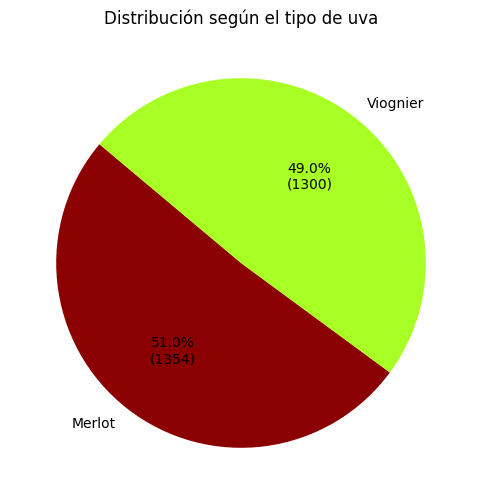

In [534]:
type_count = dataSetCurado['type'].value_counts()

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        absolute = int(round(pct * total / 100))
        return f'{pct:.1f}%\n({absolute})'
    return my_format

plt.figure(figsize=(6, 6))
plt.pie(type_count, autopct=autopct_format(type_count), startangle=140, labels=type_count.index, colors=["darkred", "#A8ff23"])
plt.title("Distribución según el tipo de uva")
plt.show()


### Fixed Acidity

Vamos a utilizar un Histograma para ver la frecuencia de los datos y BoxPlot para identificar posibles Outliers

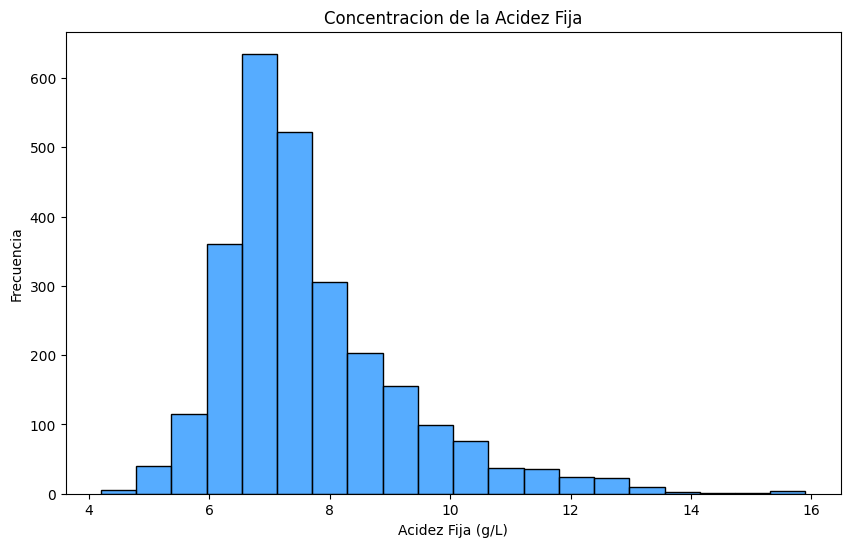

In [535]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="fixed acidity", bins=20, color="#1E90FF")
plt.title("Concentracion de la Acidez Fija")
plt.xlabel("Acidez Fija (g/L)")
plt.ylabel("Frecuencia")
plt.show()

Ahora analizamos la distribucion por tipo de uva

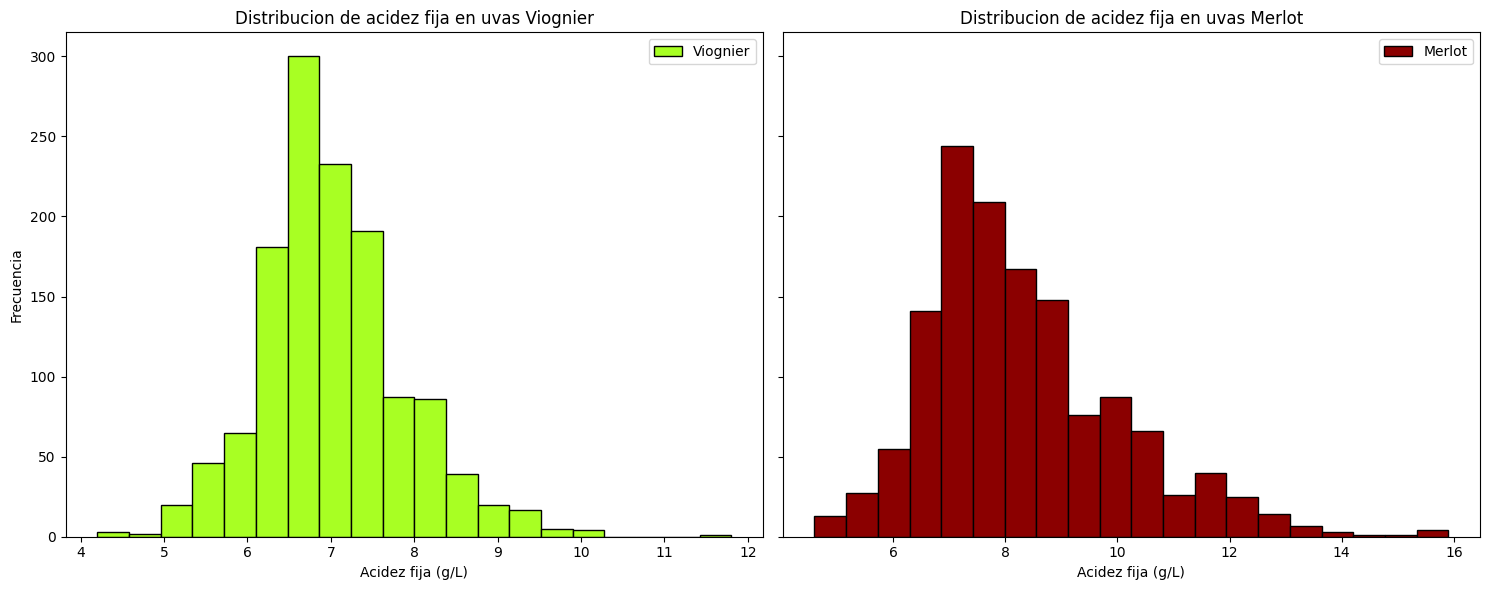

In [536]:
viognier_data = dataSetCurado[dataSetCurado['type'] == 'Viognier']
merlot_data = dataSetCurado[dataSetCurado['type'] == 'Merlot']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax1.hist(viognier_data['fixed acidity'], bins=20, color='#A8FF23', edgecolor='black', label='Viognier')
ax1.set_title('Distribucion de acidez fija en uvas Viognier')
ax1.set_xlabel('Acidez fija (g/L)')
ax1.set_ylabel('Frecuencia')
ax1.legend()

ax2.hist(merlot_data['fixed acidity'], bins=20, color='darkred', edgecolor='black', label='Merlot')
ax2.set_title('Distribucion de acidez fija en uvas Merlot')
ax2.set_xlabel('Acidez fija (g/L)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

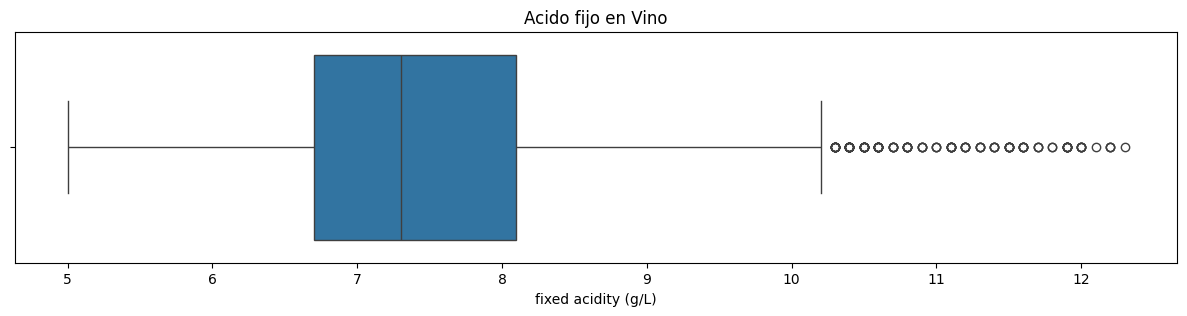

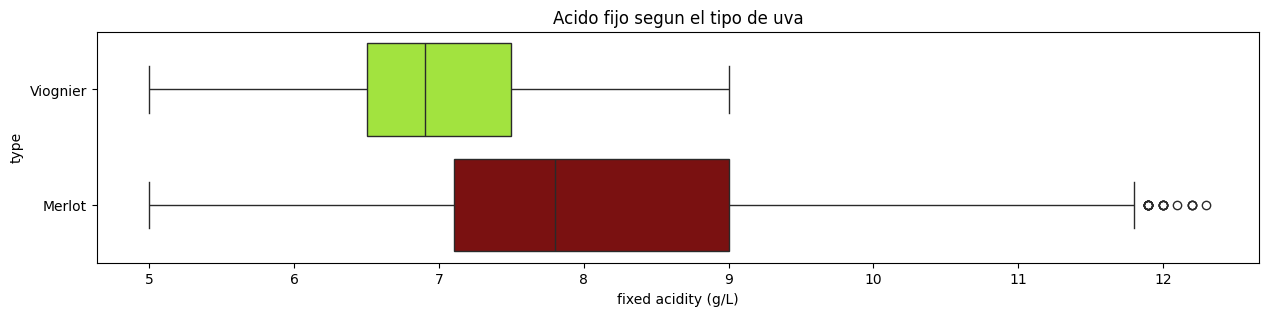

In [641]:
plt.figure(figsize=(15,3))
sns.boxplot(x='fixed acidity', data=dataSetCurado)
plt.title("Acido fijo en Vino")
plt.xlabel("fixed acidity (g/L)")
plt.show()

plt.figure(figsize=(15, 3))
sns.boxplot(x='fixed acidity', y='type', hue='type', data=dataSetCurado,  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Acido fijo segun el tipo de uva")
plt.xlabel("fixed acidity (g/L)")
plt.show()

Calculamos los bigotes superio e inferior de cada tipo de uva para eliminar los outliers

In [538]:
#Calculamos Q1 y Q3
Q1_viognier = viognier_data['fixed acidity'].quantile(0.25)
Q3_viognier = viognier_data['fixed acidity'].quantile(0.75)

Q1_merlot = merlot_data['fixed acidity'].quantile(0.25)
Q3_merlot = merlot_data['fixed acidity'].quantile(0.75)

#Calculamos el IQR
IQR_viognier = Q3_viognier - Q1_viognier
IQR_merlot = Q3_merlot - Q1_merlot

#Calculamos e limite del bigote superior
bigote_superior_viognier = Q3_viognier + 1.5 * IQR_viognier
bigote_inferior_viognier = Q1_viognier - 1.5 * IQR_viognier

bigote_superior_merlot = Q3_merlot + 1.5 * IQR_merlot

Eliminamos todos los posibles Outliers

In [539]:
fixed_acidity_viognier = dataSetCurado[(dataSetCurado['type'] == 'Viognier' ) & ((dataSetCurado['fixed acidity'] > bigote_superior_viognier) | (dataSetCurado['fixed acidity'] < bigote_inferior_viognier))]

fixed_acidity_merlot = dataSetCurado[(dataSetCurado['type'] == 'Merlot' ) & ((dataSetCurado['fixed acidity'] > bigote_superior_merlot))]

print(f"tenemos {fixed_acidity_viognier.value_counts().sum()} Outliers en los vinos Viognier y {fixed_acidity_merlot.value_counts().sum()} en los vinos Merlot")

tenemos 33 Outliers en los vinos Viognier y 41 en los vinos Merlot


Como tenemos 33 Outliers que representan el 2.5% (33/1300) del total de vinos Viognier y 41 Outiers que reoresentan el 3% (41/1359) del total de vinos Merlot, por lo que decidimos eliminarlos

In [540]:
dataSetCurado = dataSetCurado.drop(fixed_acidity_merlot.index)
dataSetCurado = dataSetCurado.drop(fixed_acidity_viognier.index)
dataSetCurado = dataSetCurado.reset_index(drop=True)

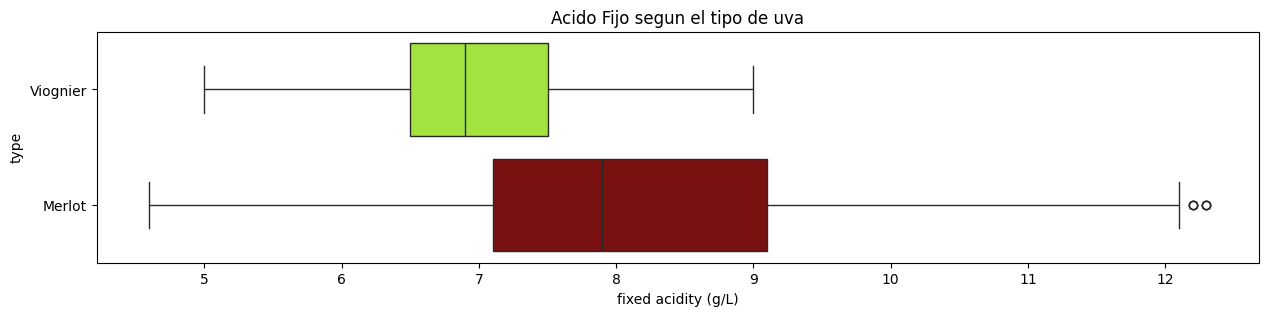

In [541]:
plt.figure(figsize=(15, 3))
sns.boxplot(x='fixed acidity', y='type', hue='type', data=dataSetCurado,  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Acido Fijo segun el tipo de uva")
plt.xlabel("fixed acidity (g/L)")
plt.show()


Aclaracion: Como dropeamos ciertas filas, ahora en el vino Merlot aparesen nuevos supuestos Outliers pero se concideran valores validos

### **Volatile Acidity**

Como primer paso realizamos un histograma para ver la distribucion por tipo de uva y un boxplot para comenzar a estudiar la variable

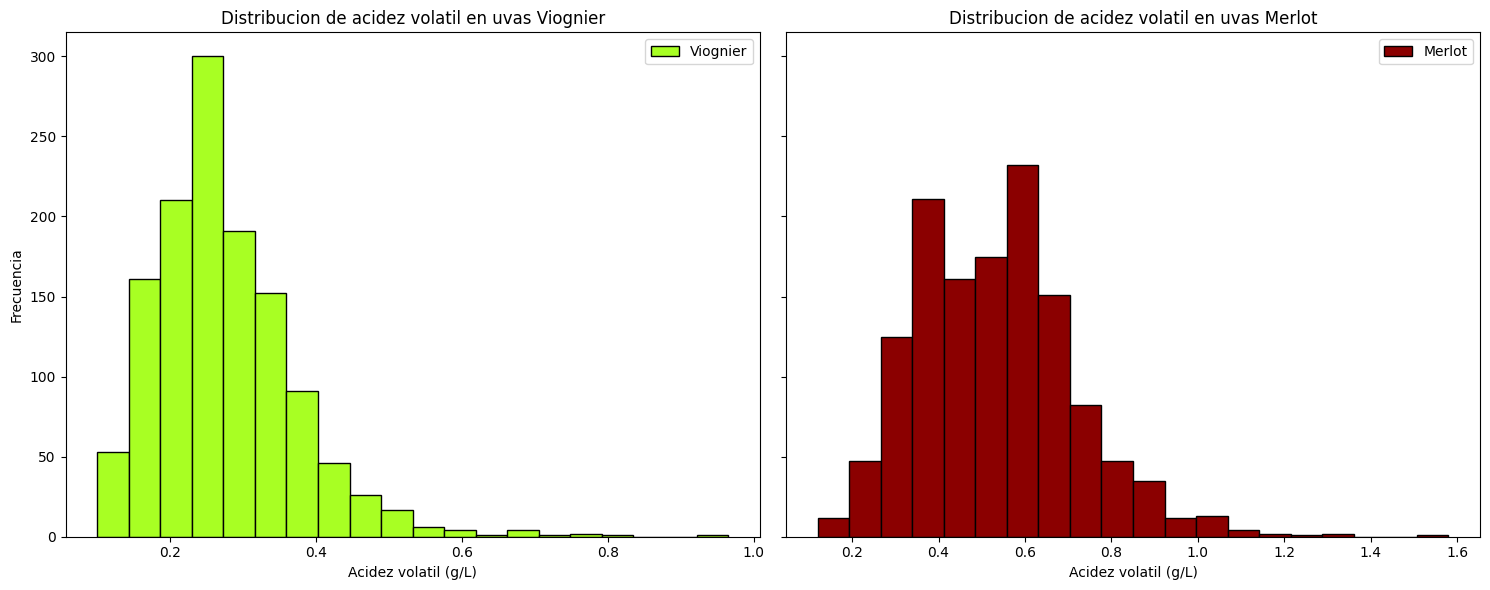

In [542]:
viognier_data = dataSetCurado[dataSetCurado['type'] == 'Viognier']
merlot_data = dataSetCurado[dataSetCurado['type'] == 'Merlot']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax1.hist(viognier_data['volatile acidity'], bins=20, color='#A8FF23', edgecolor='black', label='Viognier')
ax1.set_title('Distribucion de acidez volatil en uvas Viognier')
ax1.set_xlabel('Acidez volatil (g/L)')
ax1.set_ylabel('Frecuencia')
ax1.legend()

ax2.hist(merlot_data['volatile acidity'], bins=20, color='darkred', edgecolor='black', label='Merlot')
ax2.set_title('Distribucion de acidez volatil en uvas Merlot')
ax2.set_xlabel('Acidez volatil (g/L)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

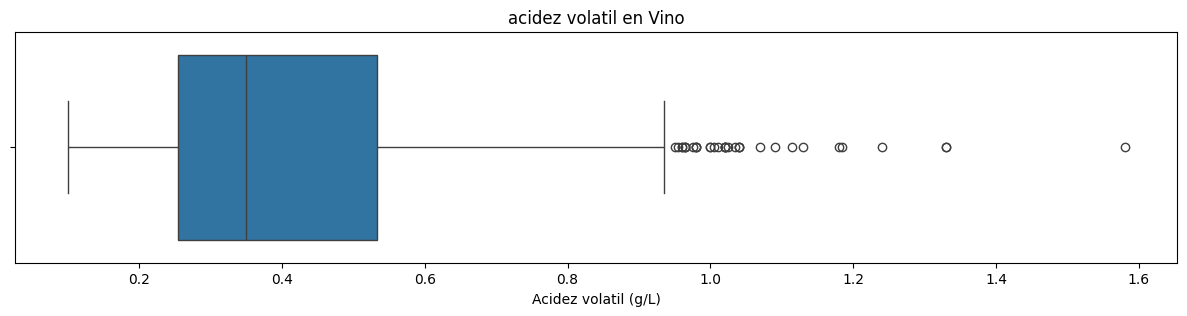

In [543]:
plt.figure(figsize=(15,3))
sns.boxplot(x='volatile acidity', data=dataSetCurado)
plt.title("acidez volatil en Vino")
plt.xlabel("Acidez volatil (g/L)")
plt.show()

Por lo que investigamos llegamos a la conclusion de que todos los vinos con una acidez volatil mayor a 1 g/l son vinos que estan picados por lo que utilizamos lo siguiente para poder ver cuantos vinos picados tenemos en el dataset

In [544]:
volatile_acidity = dataSetCurado[dataSetCurado['volatile acidity'] > 1]
volatile_acidity.value_counts().sum()

np.int64(21)

Podemos ver que tenemos 21 vinos picados o "defectuosos", por lo tanto vamos a eliminarlos

In [545]:
dataSetCurado = dataSetCurado[dataSetCurado['volatile acidity'] <= 1]

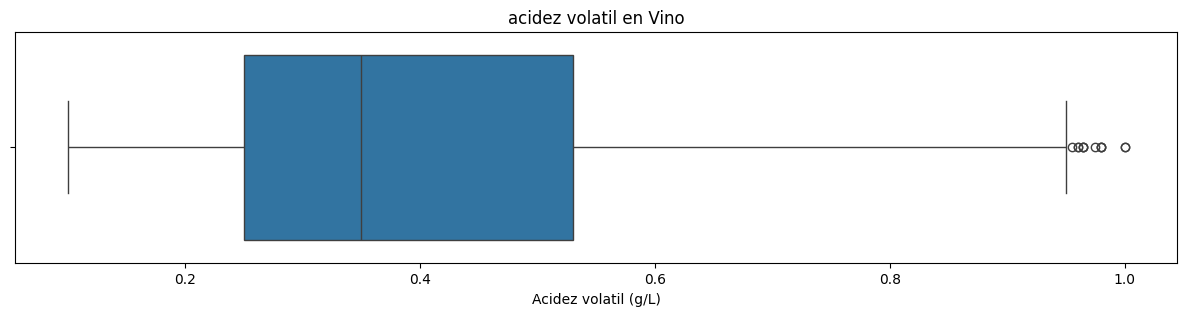

In [546]:
plt.figure(figsize=(15,3))
sns.boxplot(x='volatile acidity', data=dataSetCurado)
plt.title("acidez volatil en Vino")
plt.xlabel("Acidez volatil (g/L)")
plt.show()

Ahora veamos segun el tipo de uva

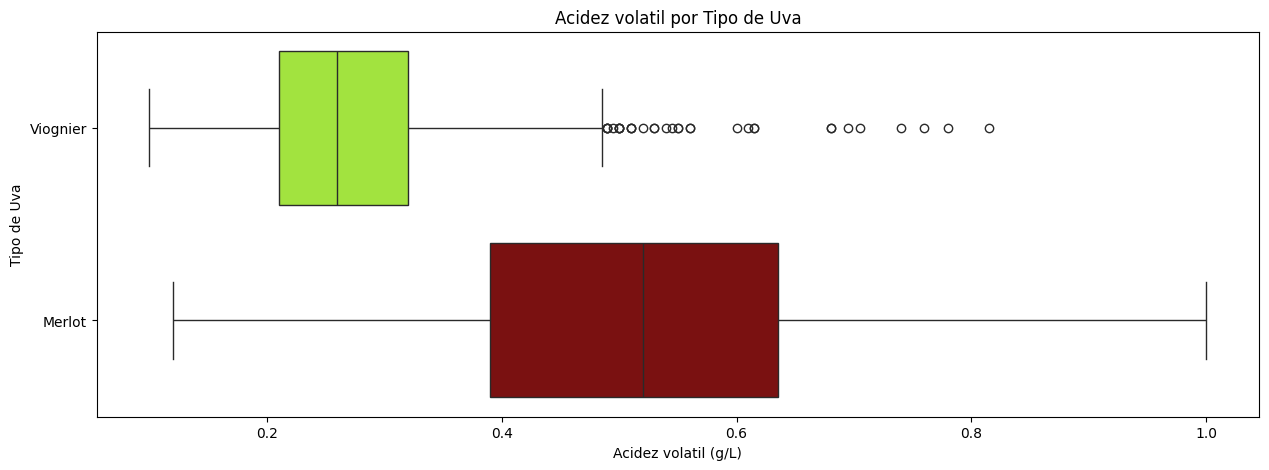

In [642]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=dataSetCurado, y="type", x="volatile acidity",hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Acidez volatil por Tipo de Uva")
plt.ylabel("Tipo de Uva")
plt.xlabel("Acidez volatil (g/L)")
plt.show()

### Citric Acid

Hacemos un boxplot para analizar supuestos Outliers y un Histograma para ver la distribucion de la variable

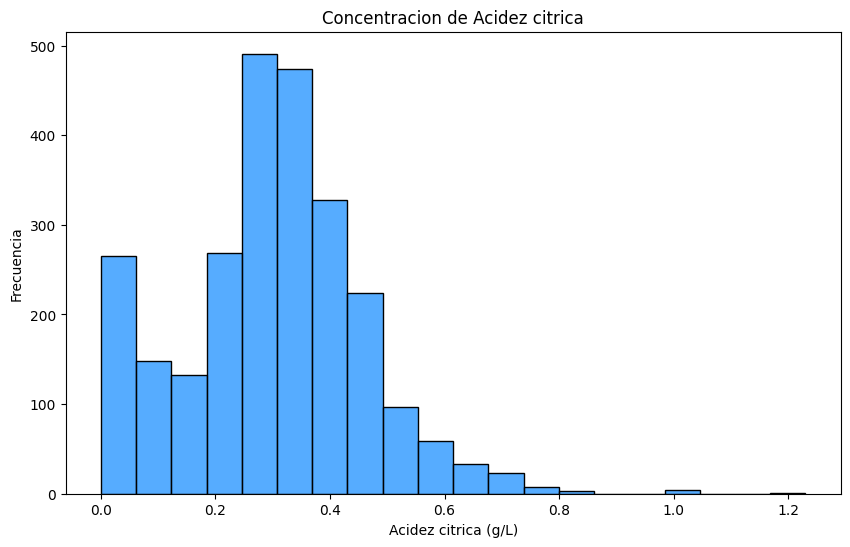

In [548]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="citric acid", bins=20, color="#1E90FF")
plt.title("Concentracion de Acidez citrica")
plt.xlabel("Acidez citrica (g/L)")
plt.ylabel("Frecuencia")
plt.show()

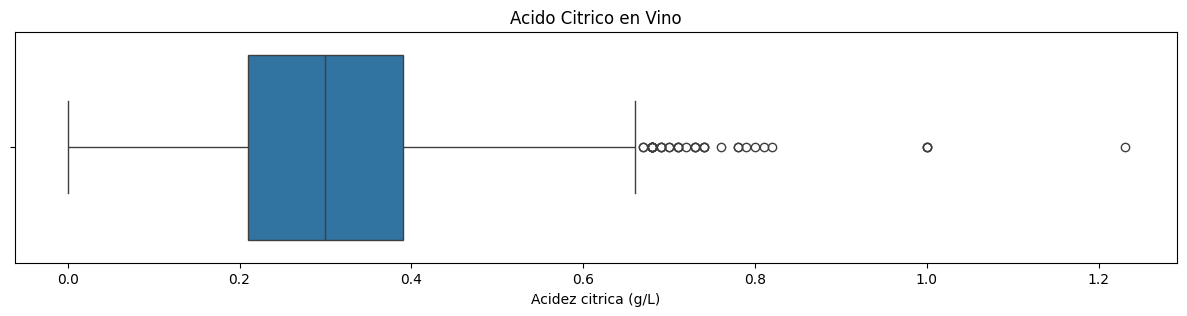

In [643]:
plt.figure(figsize=(15,3))
sns.boxplot(x='citric acid', data=dataSetCurado)
plt.title("Acido Citrico en Vino")
plt.xlabel("Acidez citrica (g/L)")
plt.show()

[La cantidad máxima legal de acido citrico en vino es de 1 g/l](https://www.agrovin.com/agrv/pdf/enologia/productos_enologicos/es/ACIDO_CITRICO_es.pdf).

Chequeamos los valores mayores a 1 g/l.

In [550]:
dataSetCurado[dataSetCurado['citric acid'] > 1]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1176,Viognier,7.6,0.25,1.23,4.6,0.035,51.0,294.0,0.99018,3.03,0.43,13.1,6


Este vino puede ser ilegal (depende del pais), pero decidimos mantenerlo en el dataset ya que no sabemos de que pais son las muestras. Al ser una fila no influye en la informacion del DataSet.

### **Density**

Hacemos un BoxPlot para analizar posibles Outliers

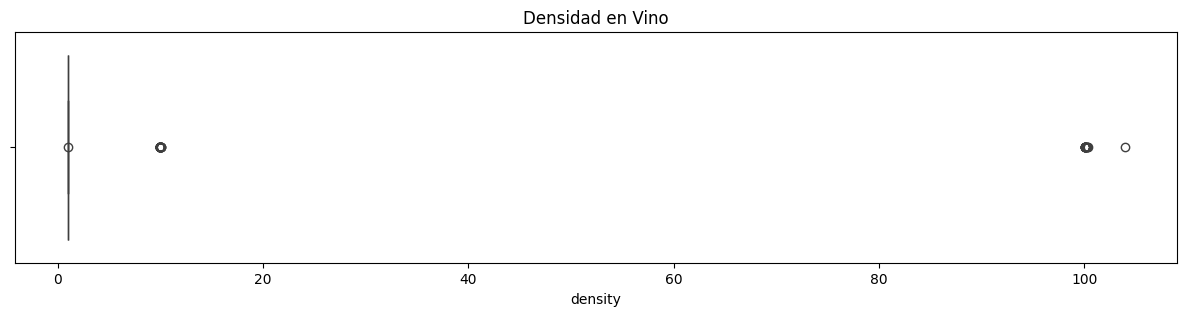

In [551]:
plt.figure(figsize=(15,3))
sns.boxplot(x='density', data=dataSetCurado)
plt.title("Densidad en Vino")
plt.show()

Como se puede apreciar, tenemos OutLiers con una dencidad mucho mayor a 1.1 g/cm³, lo cual no tiene sentido ya [la densidad de los vinos varia entre 0.9912 g/cm³ y 1.0138 g/cm³](https://pmc.ncbi.nlm.nih.gov/articles/PMC10489813/#:~:text=This%20means%20that%20the%20density,%2Fcm3%20%5B31%5D).

Chequeamos la cantidad de OutLiers que tenemos

In [552]:
cant_outliers = dataSetCurado['density'][dataSetCurado['density'] > 1.1].value_counts().sum()
cant_outliers

np.int64(58)

Tenemos 58 vinos con una densidad mayor a 1.1 g/cm³. Como no podemos validar que las demas variables de estas filas esten medidas correctamente, optamos por eliminar dichas filas, ademas son pocas en comparacion a la cantidad total, por lo tanto no va a afectar a gran escala la informacion

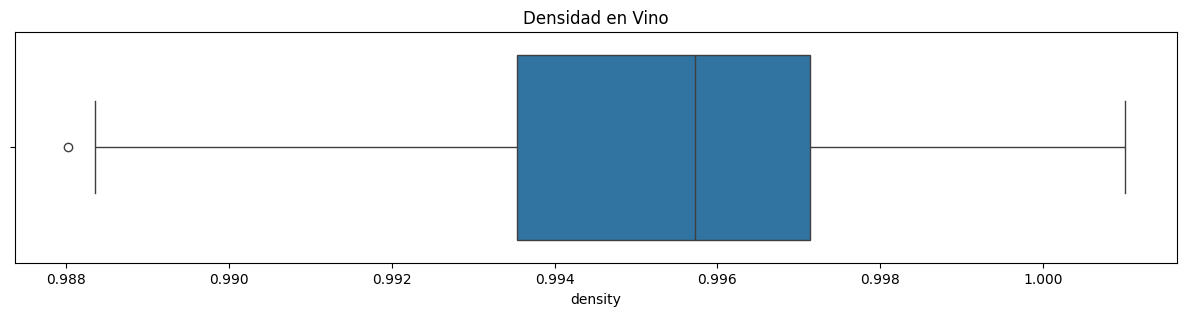

In [553]:
dataSetCurado = dataSetCurado[dataSetCurado['density'] <= 1.1]
plt.figure(figsize=(15,3))
sns.boxplot(x='density', data=dataSetCurado)
plt.title("Densidad en Vino")
plt.show()

Ahora comparamos la densidad segun el tipo de uva

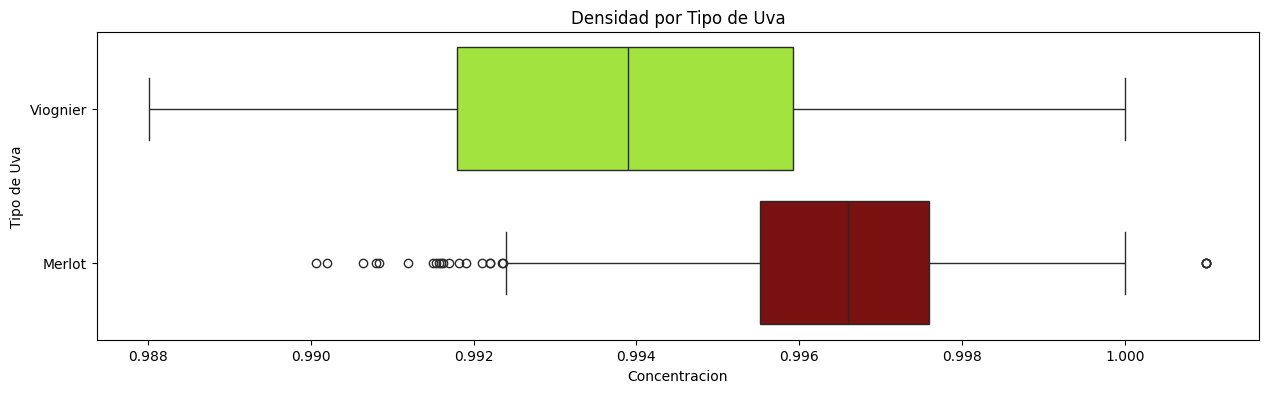

In [554]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=dataSetCurado, y="type", x="density",hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Densidad por Tipo de Uva")
plt.ylabel("Tipo de Uva")
plt.xlabel("Concentracion")
plt.show()

Esos Outliers que aparecen son aceptados ya que no estan tan alejados de los valores normales del vino.

### **Residual Sugar**

Analisis de la cantidad de azucar residual medida en gramos por litro (g/l) segun el tipo de vino

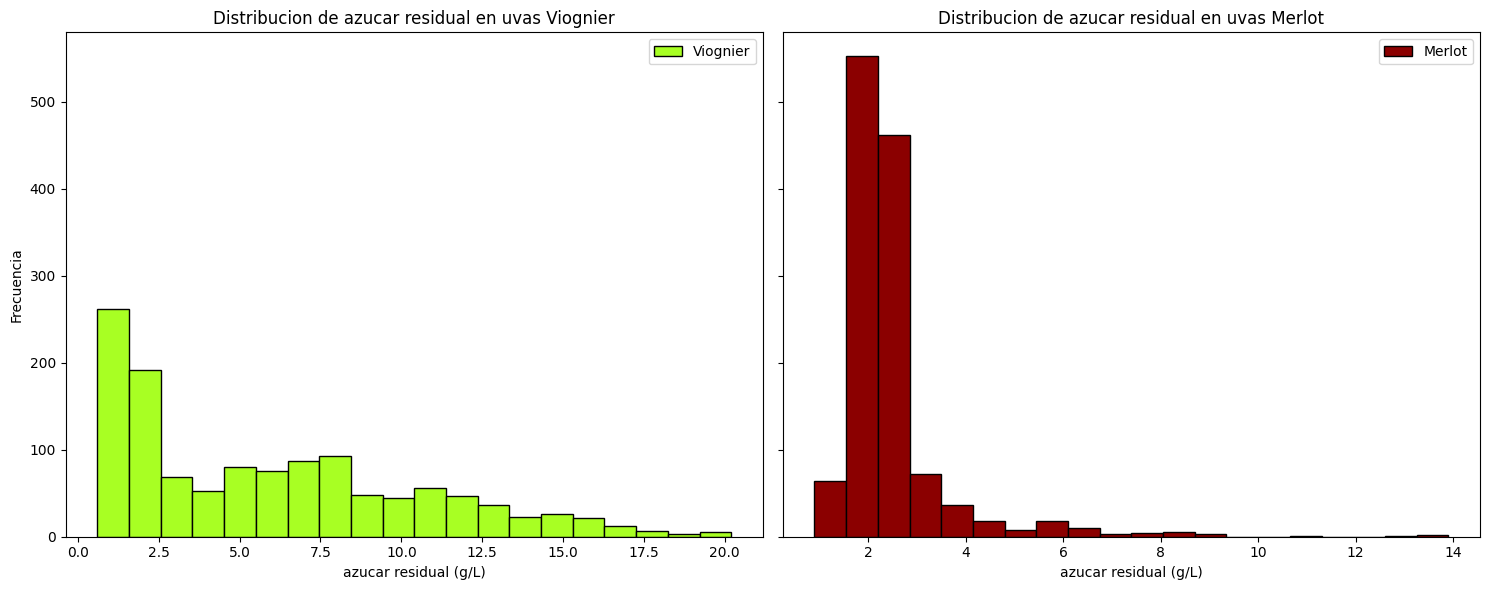

In [555]:
viognier_data = dataSetCurado[dataSetCurado['type'] == 'Viognier']
merlot_data = dataSetCurado[dataSetCurado['type'] == 'Merlot']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax1.hist(viognier_data['residual sugar'], bins=20, color='#A8FF23', edgecolor='black', label='Viognier')
ax1.set_title('Distribucion de azucar residual en uvas Viognier')
ax1.set_xlabel('azucar residual (g/L)')
ax1.set_ylabel('Frecuencia')
ax1.legend()

ax2.hist(merlot_data['residual sugar'], bins=20, color='darkred', edgecolor='black', label='Merlot')
ax2.set_title('Distribucion de azucar residual en uvas Merlot')
ax2.set_xlabel('azucar residual (g/L)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

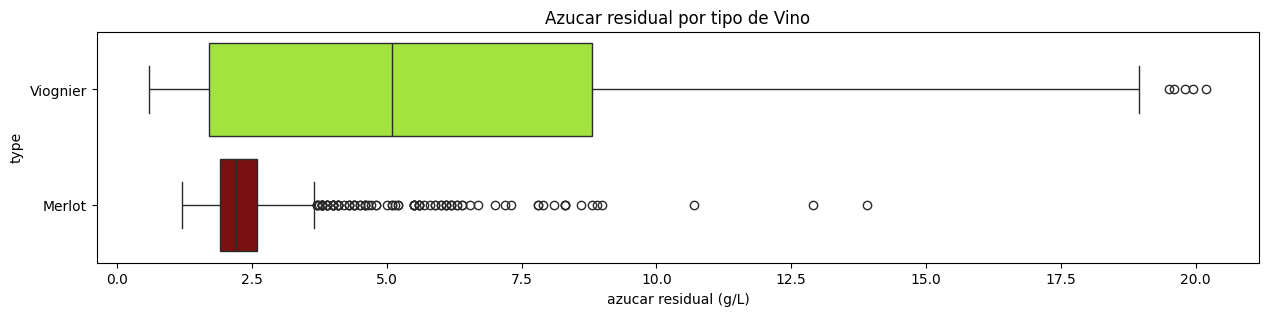

In [644]:
plt.figure(figsize=(15,3))
sns.boxplot(x='residual sugar', y='type', hue='type',data=dataSetCurado, palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Azucar residual por tipo de Vino")
plt.xlabel("azucar residual (g/L)")
plt.show()

Vemos que tenemos muchos supuestos Outliers en uvas Merlot.

Contamos la cantidad de supuestos OutLiers que tenemos

In [557]:
#Calculamos Q1 y Q3
Q1 = dataSetCurado[dataSetCurado['type'] == 'Merlot']['residual sugar'].quantile(0.25)
Q3 = dataSetCurado[dataSetCurado['type'] == 'Merlot']['residual sugar'].quantile(0.75)

#Calculamos el IQR
IQR = Q3 - Q1

#Calculamos e limite del bigote superior
bigote_superior = Q3 + 1.5 * IQR

print(f"Tenemos {dataSetCurado[(dataSetCurado['residual sugar'] > bigote_superior) & (dataSetCurado['type'] == 'Merlot')].value_counts().sum()} supuestos OutLiers que tienen {bigote_superior:.2f} g/L de azucar residual")

Tenemos 109 supuestos OutLiers que tienen 3.56 g/L de azucar residual


Estos "OutLiers" tienen valores mayores a 3.56 g/L, pero [los Vinos dulces pueden tener mas de 45 g/l de azucar residual](https://glossaire.wein.plus/azucar-residual), por lo tanto no vamos a conciderar estos valores como Outliers.

### **Total sulfur dioxide**

Hacemos un Histograma para analizar la frecuencia de los datos segun el tipo de uva, y luego un BoxPlot para identificar posibles OutLiers

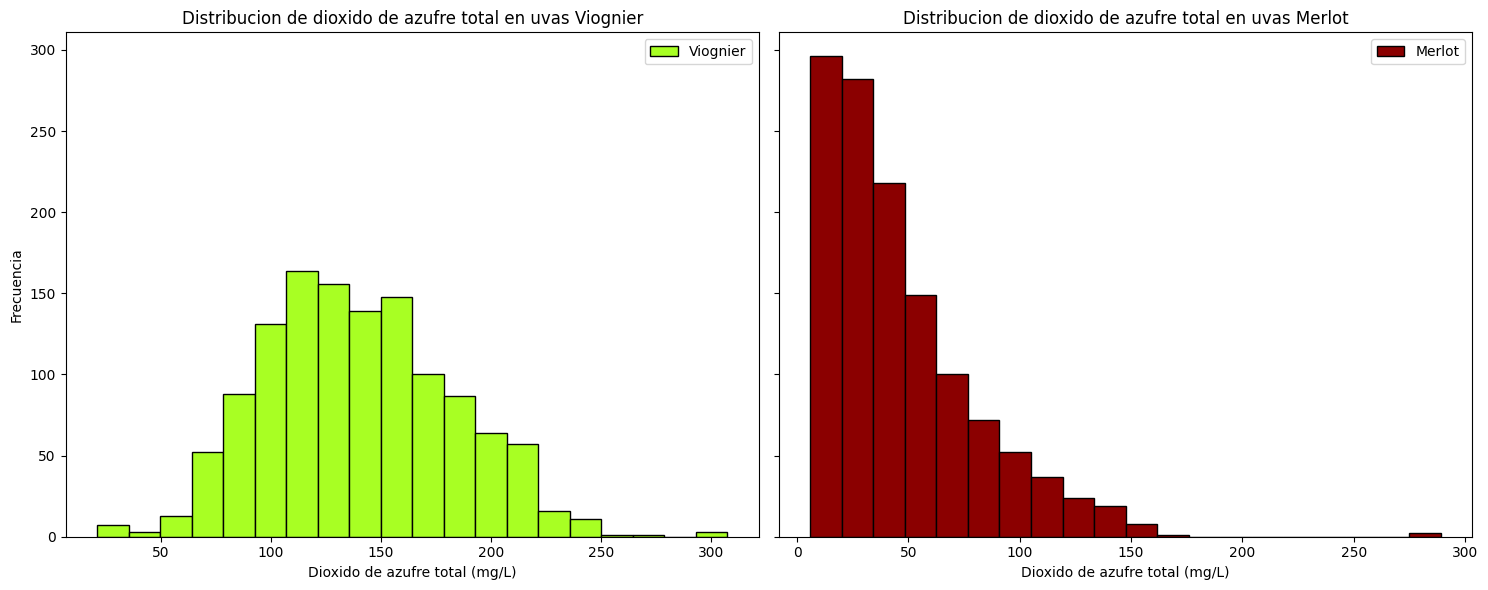

In [558]:
viognier_data = dataSetCurado[dataSetCurado['type'] == 'Viognier']
merlot_data = dataSetCurado[dataSetCurado['type'] == 'Merlot']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax1.hist(viognier_data['total sulfur dioxide'], bins=20, color='#A8FF23', edgecolor='black', label='Viognier')
ax1.set_title('Distribucion de dioxido de azufre total en uvas Viognier')
ax1.set_xlabel('Dioxido de azufre total (mg/L)')
ax1.set_ylabel('Frecuencia')
ax1.legend()

ax2.hist(merlot_data['total sulfur dioxide'], bins=20, color='darkred', edgecolor='black', label='Merlot')
ax2.set_title('Distribucion de dioxido de azufre total en uvas Merlot')
ax2.set_xlabel('Dioxido de azufre total (mg/L)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

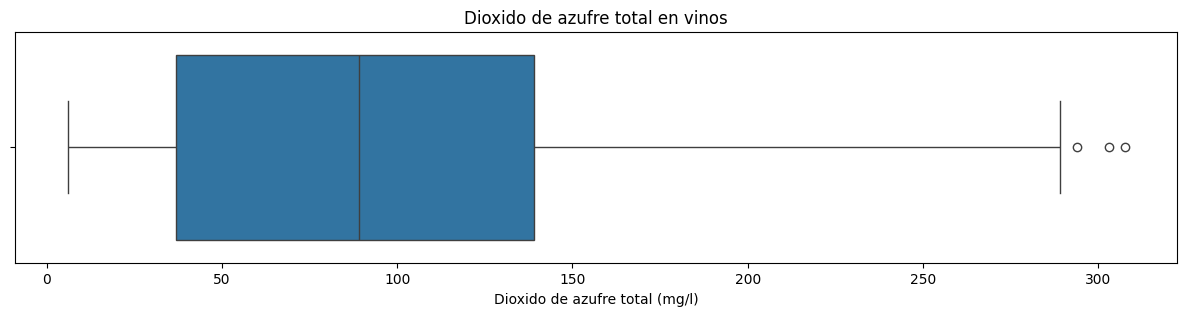

In [559]:
plt.figure(figsize=(15,3))
sns.boxplot(x='total sulfur dioxide',data=dataSetCurado)
plt.title("Dioxido de azufre total en vinos")
plt.xlabel("Dioxido de azufre total (mg/l)")
plt.show()

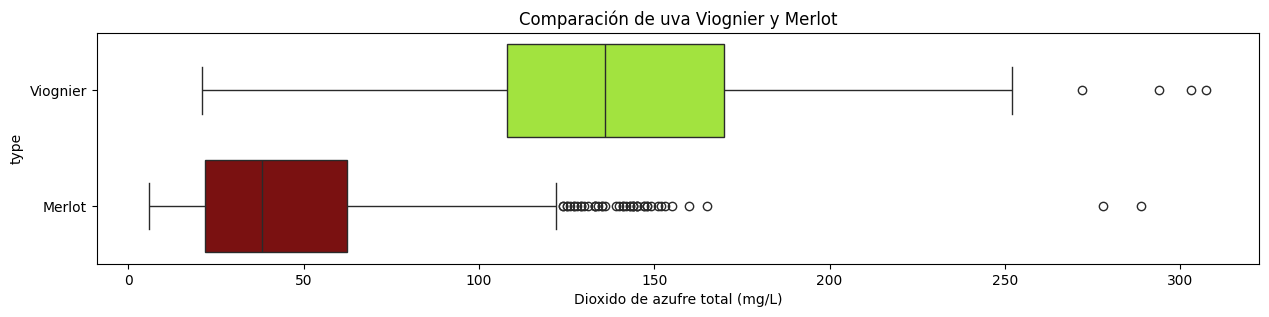

In [560]:
plt.figure(figsize=(15, 3))
sns.boxplot(x='total sulfur dioxide', y='type', hue='type', data=dataSetCurado,  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Comparación de uva Viognier y Merlot")
plt.xlabel("Dioxido de azufre total (mg/L)")
plt.show()

Los vinos blancos, como los Viognier, tienen [una cantidad de dioxido de azufre total de hasta 200 mg/l, mientras que los vinos tintos, como los Merlot, tiene una cantidad menor que 150 mg/l.](https://cientisol.com/guia-definitiva-sobre-el-analisis-quimico-del-vino-que-parametros-hay-que-medir-y-como-hacerlo/)

Para los blancos y tintos con más de 4 g/l de azúcar, su  maximo es  300 mg/l de dioxido de azufre total.

Vamos a tomar los vinos Merlot con valores de dioxido de azufre total mayores a 150 mg/l y con una azucar residual menor a 4 g/L como Outliers.

In [561]:
print(f" Hay {dataSetCurado[(dataSetCurado['total sulfur dioxide'] > 150 ) & (dataSetCurado['residual sugar'] < 4) & (dataSetCurado['type'] == 'Merlot')].value_counts().sum()} vinos Merlot que tienen una cantidad de dioxido de azufre total mayor a 150 mg/l y menos de 4 g/L de azucar")

sulfur_dioxide_merlot = dataSetCurado[(dataSetCurado['total sulfur dioxide'] > 150) & (dataSetCurado['residual sugar'] < 4) & (dataSetCurado['type'] == 'Merlot')]

 Hay 4 vinos Merlot que tienen una cantidad de dioxido de azufre total mayor a 150 mg/l y menos de 4 g/L de azucar


Ahora vamos a tomar los vinos Viognier con valores de dioxido de azufre total mayores a 200 mg/l y con una azucar residual menor a 4 g/L como Outliers.

In [562]:
print(f" Hay {dataSetCurado[(dataSetCurado['total sulfur dioxide'] > 200 ) & (dataSetCurado['residual sugar'] < 4) & (dataSetCurado['type'] == 'Viognier')].value_counts().sum()} vinos Viognier que tienen una cantidad de dioxido de azufre total mayor a 200 mg/l y menos de 4 g/L de azucar")

sulfur_dioxide_viognier = dataSetCurado[(dataSetCurado['total sulfur dioxide'] > 200) & (dataSetCurado['residual sugar'] < 4) & (dataSetCurado['type'] == 'Viognier')]

 Hay 13 vinos Viognier que tienen una cantidad de dioxido de azufre total mayor a 200 mg/l y menos de 4 g/L de azucar


Como estos vinos tienen valores invalidos ,los cuales infierien en la consistencia de los datos, procedemos a eliminarlos

In [563]:
dataSetCurado = dataSetCurado.drop(sulfur_dioxide_viognier.index)
dataSetCurado = dataSetCurado.drop(sulfur_dioxide_merlot.index)
dataSetCurado = dataSetCurado.reset_index(drop=True)

### **Sulphates**

Primero Hacemos un histograma para analizar la distribucion de la variable

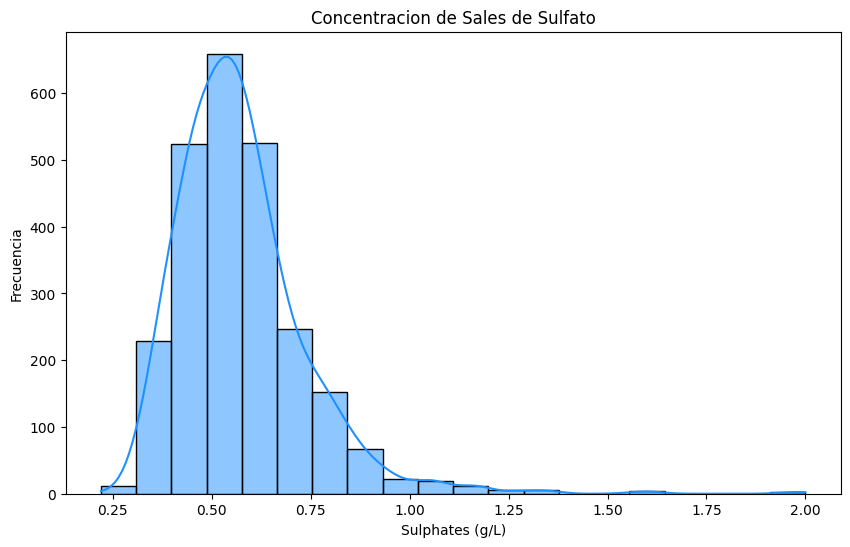

In [564]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="sulphates", bins=20, kde=True, color="#1E90FF")
plt.title("Concentracion de Sales de Sulfato")
plt.xlabel("Sulphates (g/L)")
plt.ylabel("Frecuencia")
plt.show()

Existen algunos valores de sulfatos que son significativamente más altos, alcanzando hasta 2.0 g/L en casos aislados, por lo que en esos valores tenemos posibles outliers.
Realizamos un boxplot para analizarlo mejor

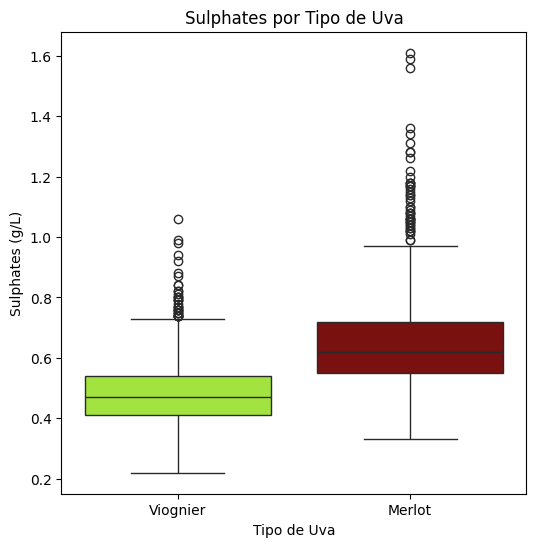

In [645]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=dataSetCurado, x="type", y="sulphates",hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Sulphates por Tipo de Uva")
plt.xlabel("Tipo de Uva")
plt.ylabel("Sulphates (g/L)")
plt.show()

Como la informacion que hay sobre la cantidad de sulfato en los vinos no es certera, no podemos validar o no los supuetos Outliers, por lo tanto los dejamos en el DataSet

### **pH**

Primero Realizamos un histograma para analizar la distribucion: 

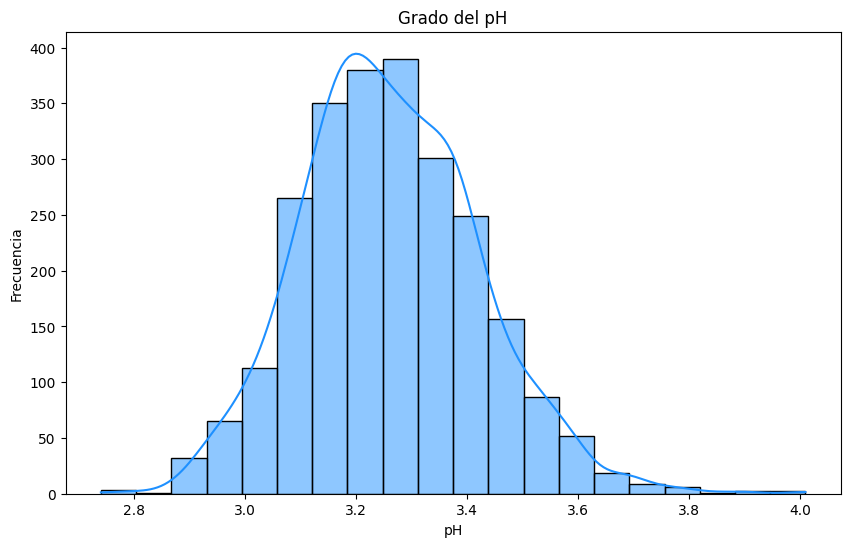

In [566]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="pH", bins=20, kde=True, color="#1E90FF")
plt.title("Grado del pH")
plt.xlabel("pH")
plt.ylabel("Frecuencia")
plt.show()

En el histograma se puede observar que la media esta al rededor de 3.3, tenemos posibles outliers tanto del lado izquierdo de la distribucion donde rondarian el 2.8 de ph como del lado derecho donde observamos valores cercanos a 4 de pH.

Si bien estos valores no son extremos porque el pH de la mayoria de vinos se encuentre dentro de este intervalo, realizamos un boxplot para observar el nivel de pH por tipo de uva y analizar si el pH varia significativamente.

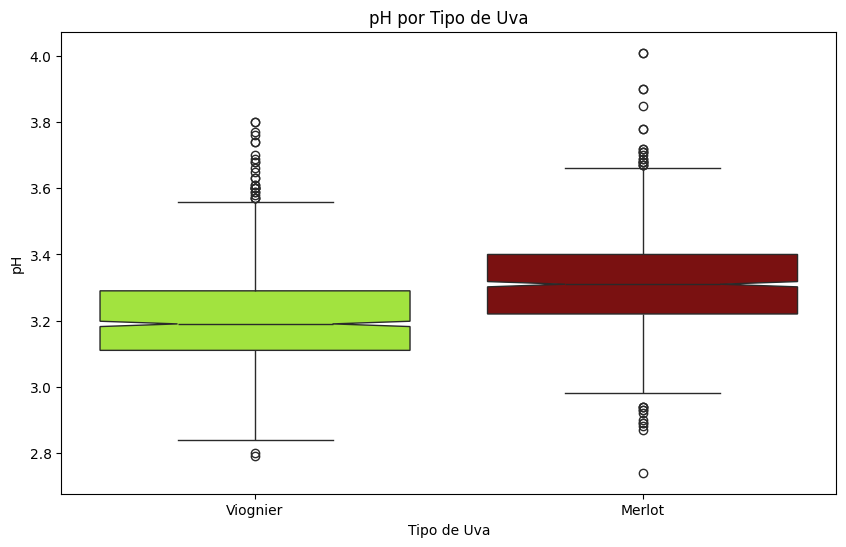

In [567]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataSetCurado, x="type", y="pH",hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"}, notch= True)
plt.title("pH por Tipo de Uva")
plt.xlabel("Tipo de Uva")
plt.ylabel("pH")
plt.show()

[Los vinos blancos suelen tener un pH entre 3 y 3,3 y la mayoría de los tintos entre 3,3 y 3,6](https://www.aprenderdevino.es/ph-y-vino/). Los valores vistos en el grafico coiciden con la informacion, sin enbargo hay muchos posibles OutLiers que son de interes analizar si son o no valores validos.

In [568]:
Q1 = dataSetCurado[dataSetCurado['type'] == 'Viognier']['pH'].quantile(0.25)
Q3 = dataSetCurado[dataSetCurado['type'] == 'Viognier']['pH'].quantile(0.75)

#Calculamos el IQR
IQR = Q3 - Q1

#Calculamos e limite del bigote superior
bigote_superior = Q3 + 1.5 * IQR


print(f"Tenemos {dataSetCurado[(dataSetCurado['pH'] > bigote_superior) & (dataSetCurado['type'] == 'Viognier')].value_counts().sum()} OutLiers")

ph_viognier = dataSetCurado[(dataSetCurado['pH'] > bigote_superior) & (dataSetCurado['type'] == 'Viognier')]

Tenemos 27 OutLiers


Como solo tenemos 27 outliers en Viognier procedemos a eliminarlos del dataset:

In [569]:
dataSetCurado = dataSetCurado.drop(ph_viognier.index)
dataSetCurado = dataSetCurado.reset_index(drop=True)

Hacemos lo mismo para los vinos merlot 

In [570]:
Q1 = dataSetCurado[dataSetCurado['type'] == 'Merlot']['pH'].quantile(0.25)
Q3 = dataSetCurado[dataSetCurado['type'] == 'Merlot']['pH'].quantile(0.75)

#Calculamos el IQR
IQR = Q3 - Q1

#Calculamos e limite del bigote superior
bigote_superior = Q3 + 1.5 * IQR
bigote_inferior = Q1 - 1.5 * IQR

print(f"Tenemos {dataSetCurado[((dataSetCurado['pH'] > bigote_superior) | (dataSetCurado['pH'] < bigote_inferior)) & (dataSetCurado['type'] == 'Merlot')].value_counts().sum()} OutLiers")

ph_merlot = dataSetCurado[((dataSetCurado['pH'] > bigote_superior) | (dataSetCurado['pH'] < bigote_inferior)) & (dataSetCurado['type'] == 'Merlot')]

Tenemos 34 OutLiers


Como son pocos outliers en Merlot procedemos a eliminarlos del dataset:

In [571]:
dataSetCurado = dataSetCurado.drop(ph_merlot.index)
dataSetCurado = dataSetCurado.reset_index(drop=True)

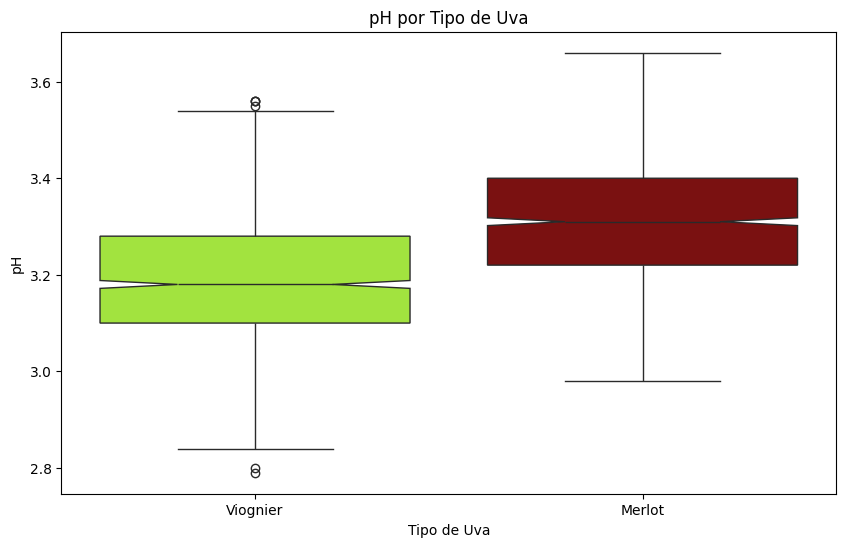

In [572]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataSetCurado, x="type", y="pH",hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"}, notch= True)
plt.title("pH por Tipo de Uva")
plt.xlabel("Tipo de Uva")
plt.ylabel("pH")
plt.show()

### **Quality**

Realizamos un histograma para comenzar a analizar la distribucion de la variable

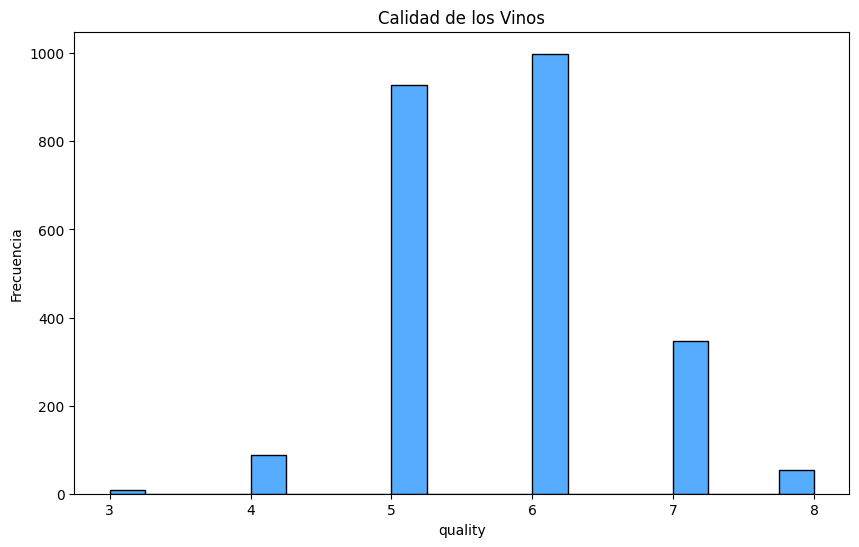

In [573]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="quality", bins=20, kde=False, color="#1E90FF")
plt.title("Calidad de los Vinos")
plt.xlabel("quality")
plt.ylabel("Frecuencia")
plt.show()

Como se puede observar en el Histograma la mayoria de los vinos se encuentran entre los valores 5 y 6, lo que indica que la media se encuentra entre estos valores.

Hacemos un grafico de barras para ver la calidad segun el tipo de uva 

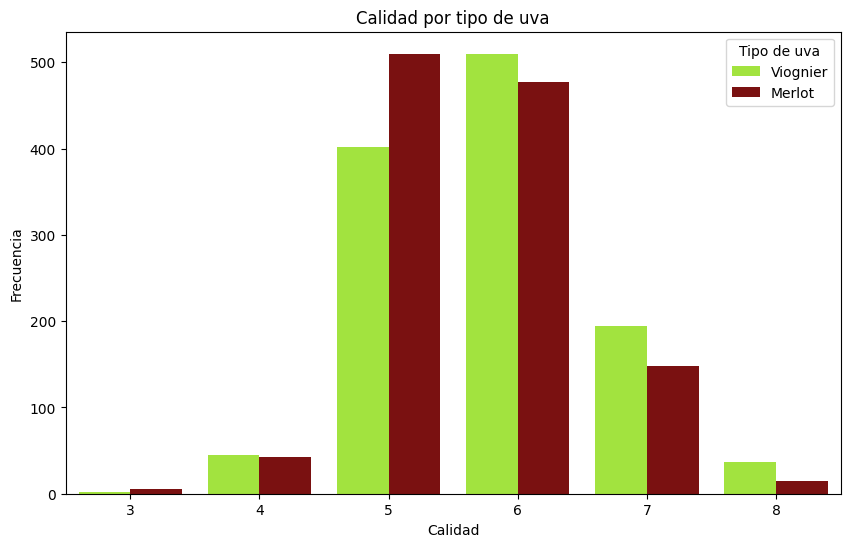

In [646]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dataSetCurado, x="quality", hue="type", palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Calidad por tipo de uva")
plt.xlabel("Calidad")
plt.ylabel("Frecuencia")
plt.legend(title="Tipo de uva")
plt.show()

### **Alcohol**

Como primer paso realizamos un boxplot para obtener un paneo general de la distribucion y un HIstograma para ver la distribucion

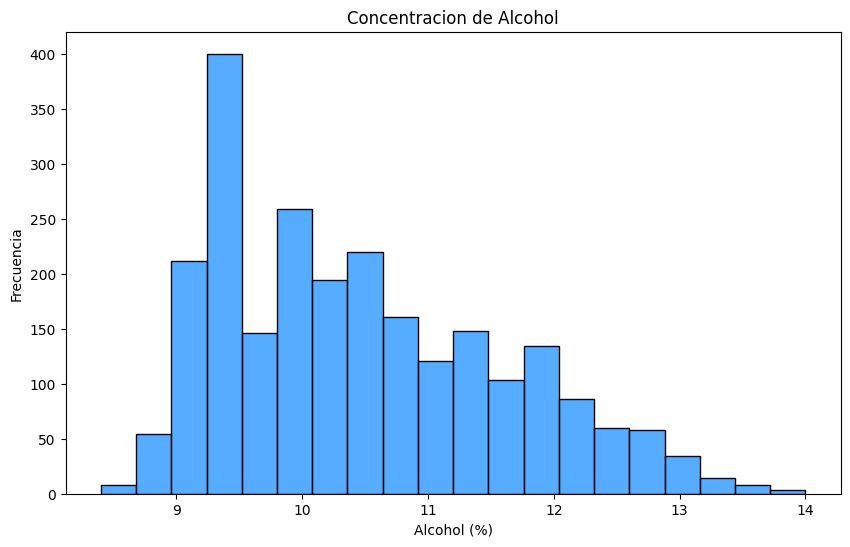

In [575]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="alcohol", bins=20, color="#1E90FF")
plt.title("Concentracion de Alcohol")
plt.xlabel("Alcohol (%)")
plt.ylabel("Frecuencia")
plt.show()

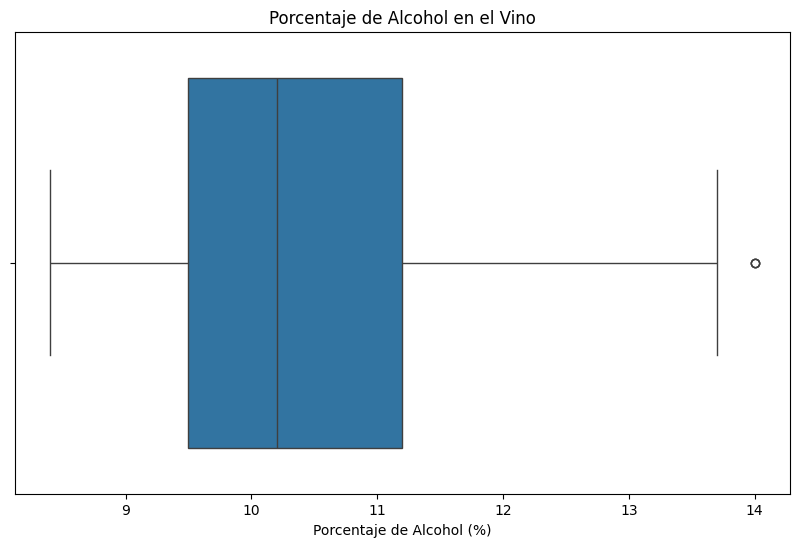

In [576]:
plt.figure(figsize=(10,6))
sns.boxplot(x='alcohol', data=dataSetCurado)
plt.title("Porcentaje de Alcohol en el Vino")
plt.xlabel("Porcentaje de Alcohol (%)")
plt.show()

Se puede observar que tenemos posibles outliers 

Realizamos un boxplot para cada tipo de vino para poder analizar 

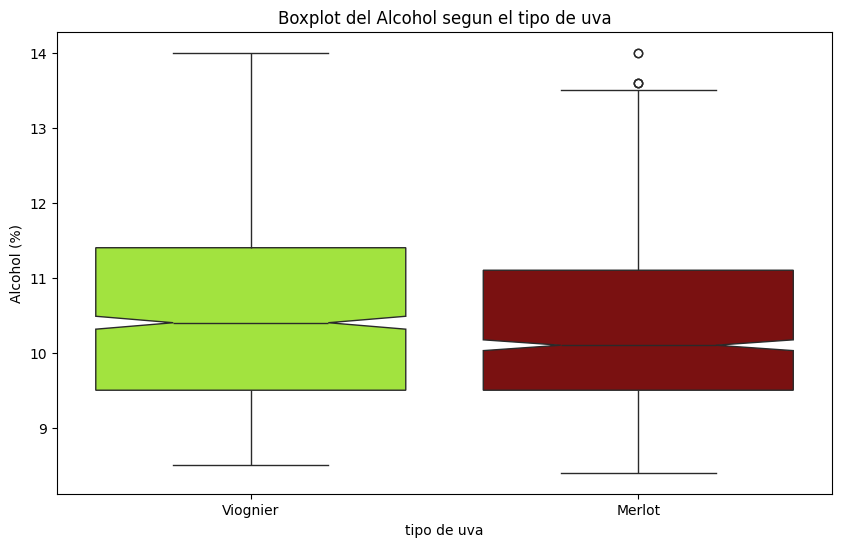

In [577]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataSetCurado, x="type", y="alcohol", notch = True,hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Boxplot del Alcohol segun el tipo de uva")
plt.xlabel("tipo de uva")
plt.ylabel("Alcohol (%)")
plt.show()

Ambos tipos de vino tienen un rango de alcohol similar (13.5% - 15%), aunque el Merlot tiende a ser más constante en este rango, mientras que el Viognier puede mostrar mayor variabilidad, como se observó en el análisis del boxplot.

### **Chlorides**

Hacemos un BoxPlot para analisar los posibles Outliers y un Histograma para ver la distribucion

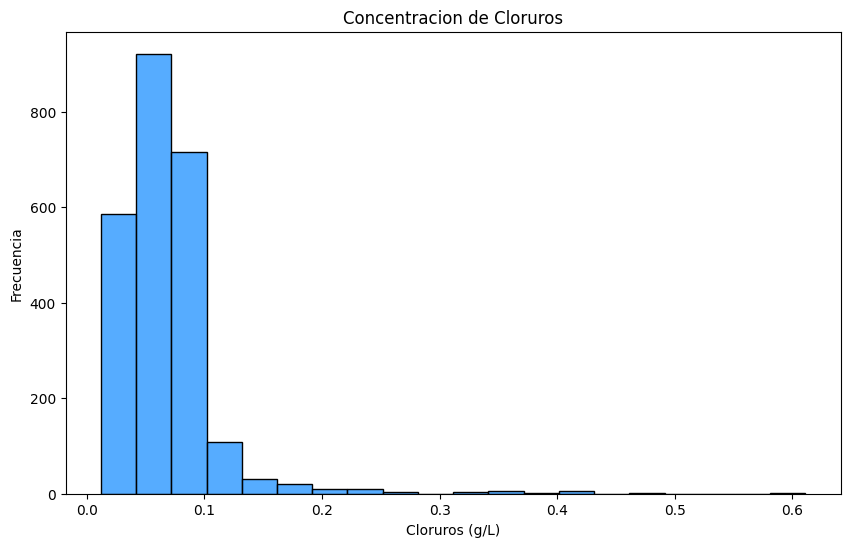

In [578]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="chlorides", bins=20, color="#1E90FF")
plt.title("Concentracion de Cloruros")
plt.xlabel("Cloruros (g/L)")
plt.ylabel("Frecuencia")
plt.show()

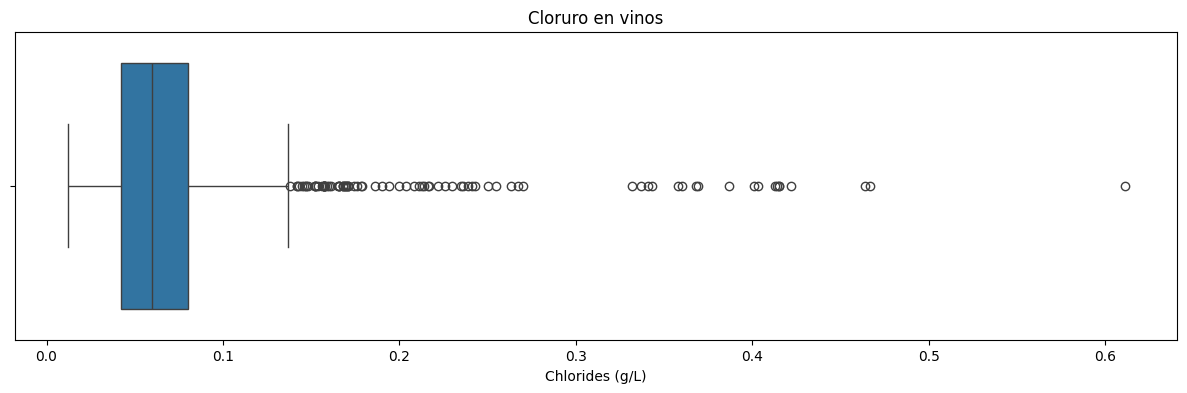

In [579]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=dataSetCurado, x="chlorides")
plt.title("Cloruro en vinos")
plt.xlabel("Chlorides (g/L)")
plt.show()

Luego realizamos un boxplot por cada tipo de uva

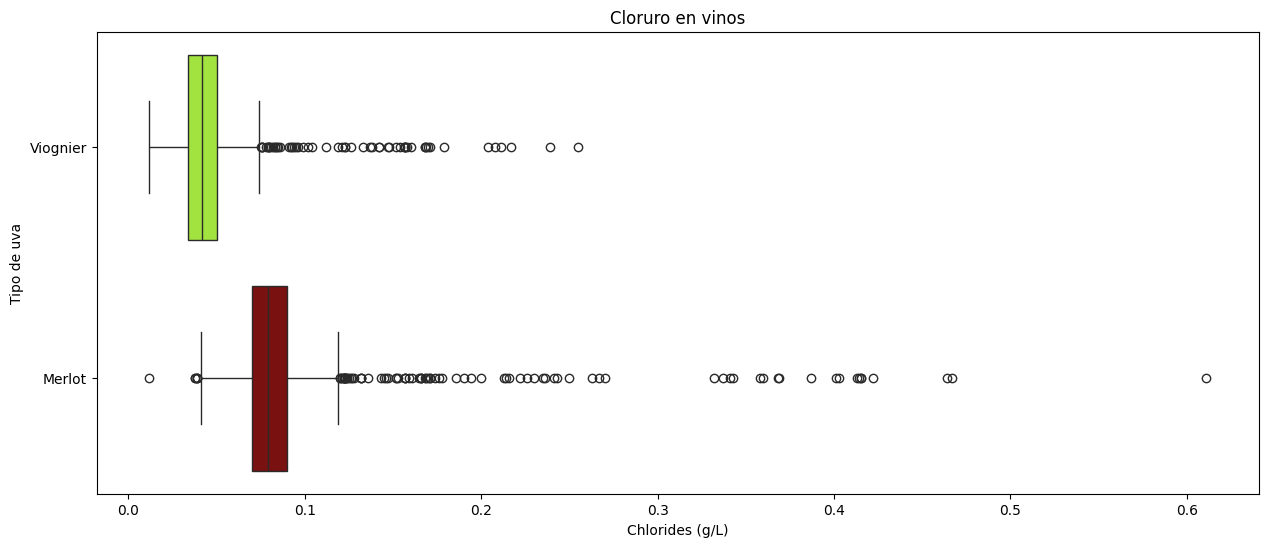

In [580]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataSetCurado, y="type", x="chlorides", hue='type',  palette={"Viognier": "#A8FF23", "Merlot": "darkred"})
plt.title("Cloruro en vinos")
plt.ylabel("Tipo de uva")
plt.xlabel("Chlorides (g/L)")
plt.show()

Los vinos con Viognier tiene unos valores de cloruro entre 0.07 a 0.18 g/L mientras que los vinos Merlot oscilan entre 0.05 y 0.15 g/Ls, pero es posible tener valor mucho mas altos (entre 0.6 y 1 g/L), asi que vamos a considerar los posibles Outliers vistos en el graficos como valores validos.

### **Free sulfur dioxide**

Hacemos un boxplot para analizar posibles Outliers y un Histograma para ver la distribucion

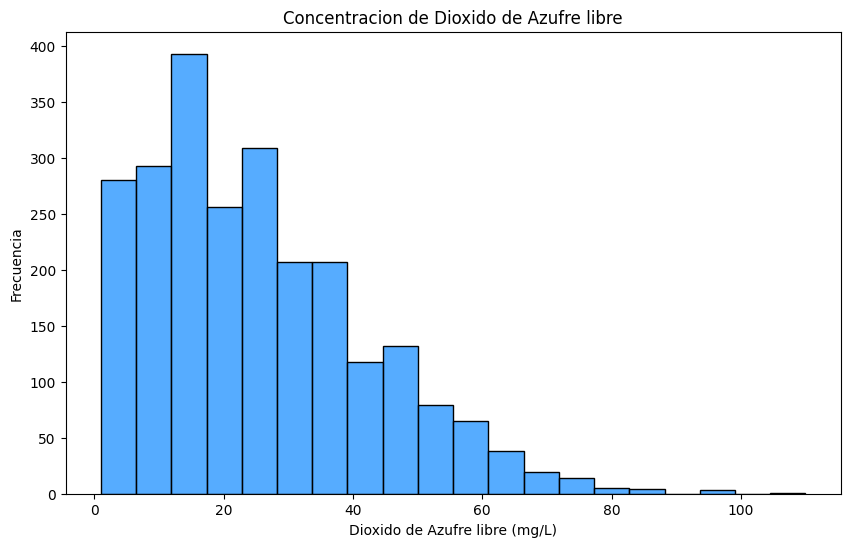

In [581]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dataSetCurado, x="free sulfur dioxide", bins=20, color="#1E90FF")
plt.title("Concentracion de Dioxido de Azufre libre")
plt.xlabel("Dioxido de Azufre libre (mg/L)")
plt.ylabel("Frecuencia")
plt.show()

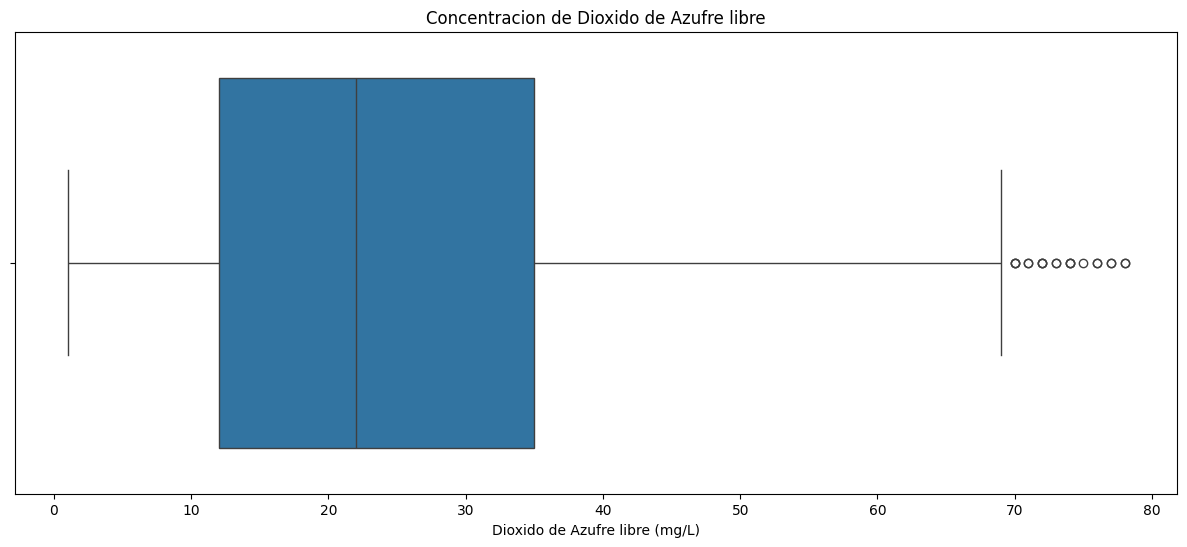

In [647]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataSetCurado, x="free sulfur dioxide")
plt.title("Concentracion de Dioxido de Azufre libre")
plt.xlabel("Dioxido de Azufre libre (mg/L)")
plt.show()

Luego realizamos un boxplot por cada tipo de uva

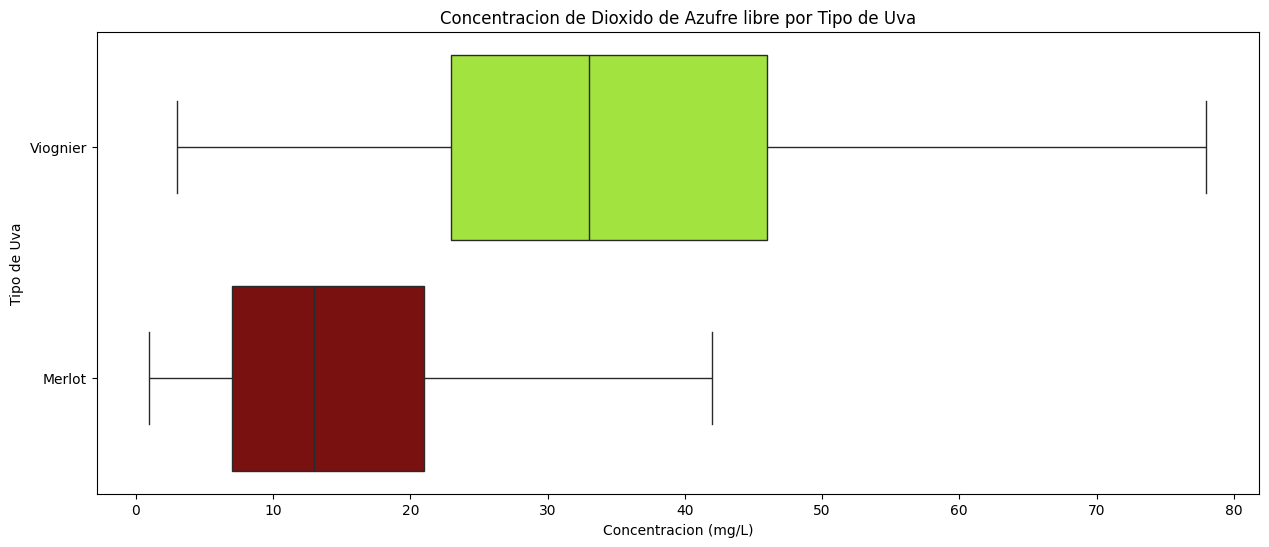

In [648]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataSetCurado, y="type", x="free sulfur dioxide",hue='type', palette={"Viognier": "#A8ff23", "Merlot": "darkred"})
plt.title("Concentracion de Dioxido de Azufre libre por Tipo de Uva")
plt.xlabel("Concentracion (mg/L)")
plt.ylabel("Tipo de Uva")
plt.show()

Procedemos a eliminar los posibles outliers ya que no encontramos informacion de una fuente veridica que indique esos valores pueden ser validos

In [584]:
#Calculamos Q1 y Q3
Q1_viognier = dataSetCurado[dataSetCurado['type'] == 'Viognier']['free sulfur dioxide'].quantile(0.25)
Q3_viognier = dataSetCurado[dataSetCurado['type'] == 'Viognier']['free sulfur dioxide'].quantile(0.75)

Q1_merlot = dataSetCurado[dataSetCurado['type'] == 'Merlot']['free sulfur dioxide'].quantile(0.25)
Q3_merlot = dataSetCurado[dataSetCurado['type'] == 'Merlot']['free sulfur dioxide'].quantile(0.75)

#Calculamos el IQR
IQR_viognier = Q3_viognier - Q1_viognier
IQR_merlot = Q3_merlot - Q1_merlot

#Calculamos e limite del bigote superior
bigote_superior_viognier = Q3_viognier + 1.5 * IQR_viognier

bigote_superior_merlot = Q3_merlot + 1.5 * IQR_merlot

Una vez que tenemos los valores de los bigotes, guardamos en dos variables las filas que  contengan los valores fuera de los bigotes

In [585]:
free_sulfur_dioxide_viognier = dataSetCurado[(dataSetCurado["type"] == 'Viognier') & (dataSetCurado['free sulfur dioxide'] > bigote_superior_viognier)]
free_sulfur_dioxide_merlot = dataSetCurado[(dataSetCurado["type"] == 'Merlot') & (dataSetCurado['free sulfur dioxide'] > bigote_superior_merlot)]

In [586]:
dataSetCurado = dataSetCurado.drop(free_sulfur_dioxide_viognier.index)
dataSetCurado = dataSetCurado.drop(free_sulfur_dioxide_merlot.index)
dataSetCurado = dataSetCurado.reset_index(drop=True)

Dropeamos las filas y luego volvemos a realizar los boxplot para analizar que se hayan eliminado las outliers 

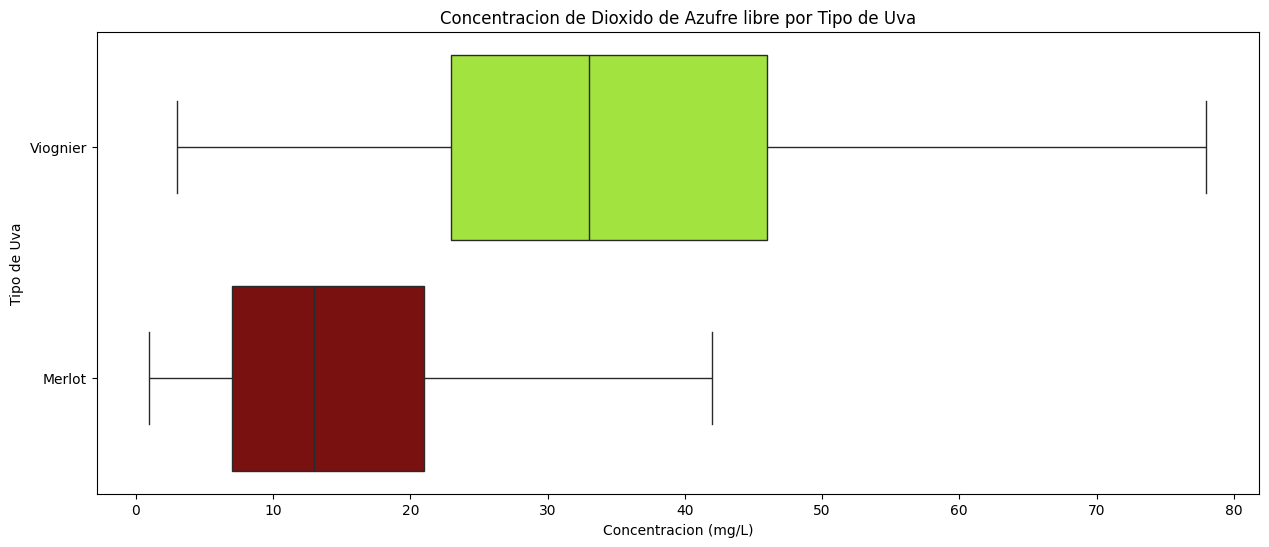

In [649]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=dataSetCurado, y="type", x="free sulfur dioxide",hue='type', palette={"Viognier": "#A8ff23", "Merlot": "darkred"})
plt.title("Concentracion de Dioxido de Azufre libre por Tipo de Uva")
plt.xlabel("Concentracion (mg/L)")
plt.ylabel("Tipo de Uva")
plt.show()

## Analisis multivariado

Lo primero que hacemos es la matriz de correlacion para detectar relaciones lineales

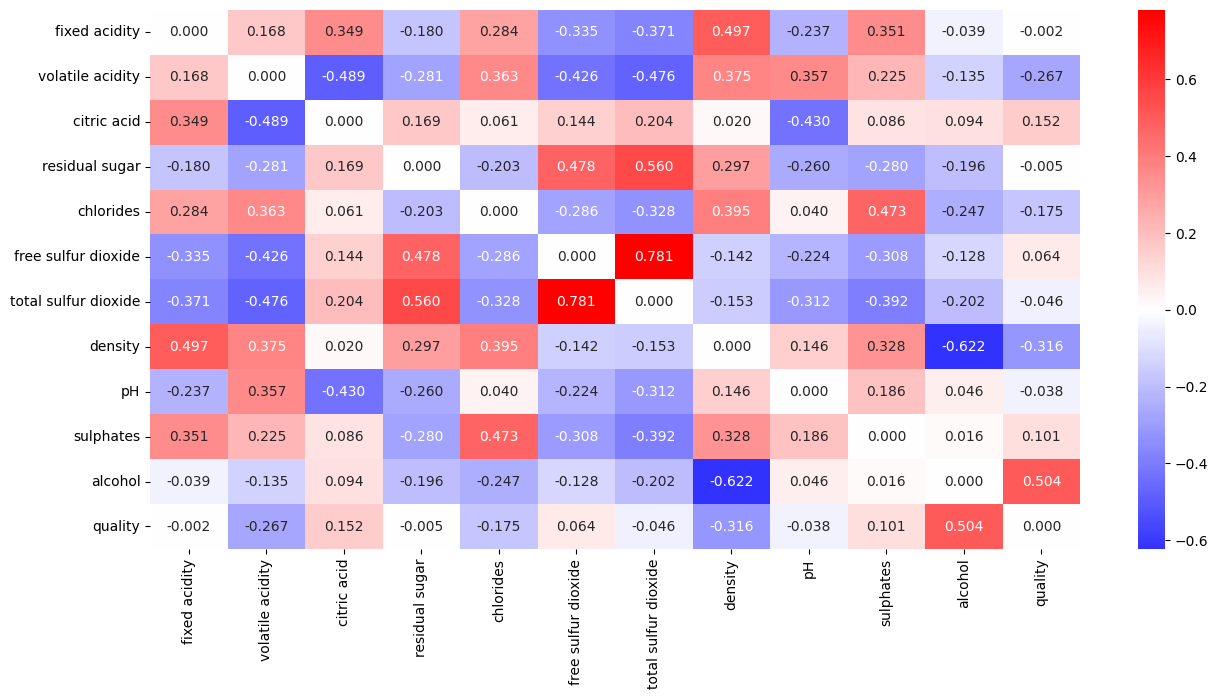

In [588]:
matrix = dataSetCurado.drop(["type"], axis=1)
matrix = matrix.corr()
np.fill_diagonal(matrix.values, 0)
plt.figure(figsize=(15,7))
sns.heatmap(matrix, center=0.0, annot=True, cmap='bwr',fmt='.3f' )
plt.show()

Decidimos analizar las variables que tengan un coeficiente de correlacion mayor a 0.5

Relaciones de interes:
- Density y Alcohol
- Quality y Alcohol

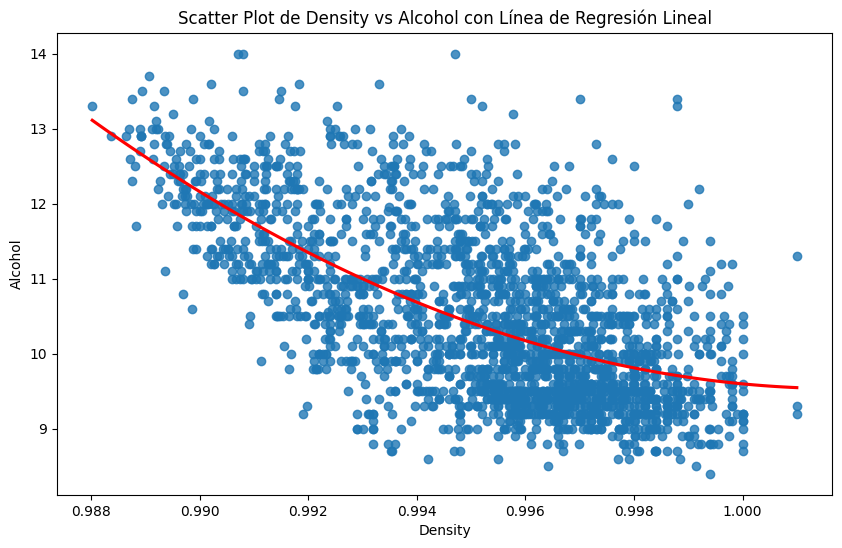

In [589]:
plt.figure(figsize=(10, 6))
sns.regplot(data=dataSetCurado, x='density', y='alcohol',order= 2, line_kws={"color": "red"}, ci=None) 
plt.title("Scatter Plot de Density vs Alcohol con Línea de Regresión Lineal")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.show()

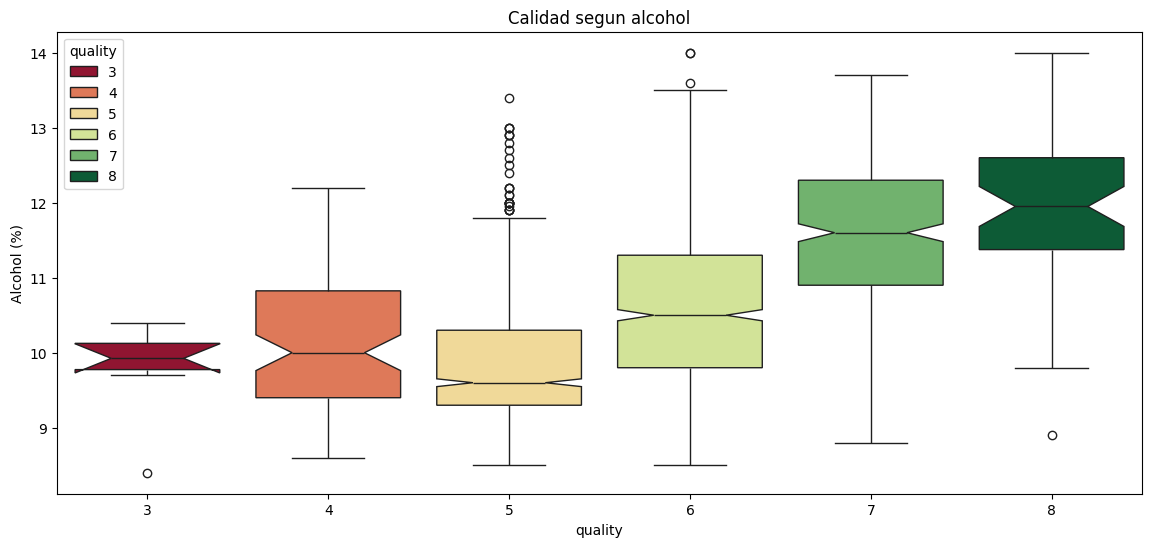

In [590]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='quality', y='alcohol', data=dataSetCurado, notch=True, palette= 'RdYlGn', hue='quality')
plt.title("Calidad segun alcohol")
plt.ylabel('Alcohol (%)')
plt.show()

Como esto nos parecio poco, decidimos separar al dataset segun su tipo de uva para comprobar si esto estaba afectando a las correlaciones.

In [591]:
dataSet_viognier = dataSetCurado[dataSetCurado['type'] == 'Viognier'].drop(["type"], axis=1).copy()
dataSet_merlot = dataSetCurado[dataSetCurado['type'] == 'Merlot'].drop(["type"], axis=1).copy()

#### Matriz de correlacion de Viognier

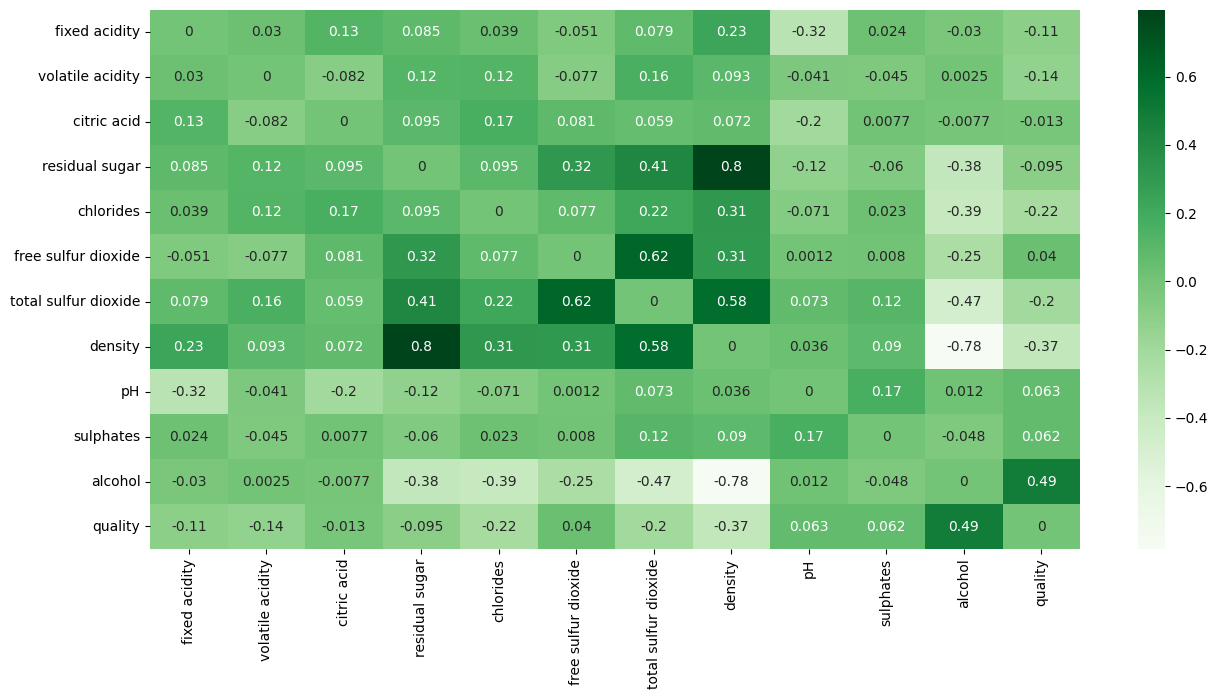

In [592]:
matrix_viognier= dataSet_viognier
matrix_viognier = matrix_viognier.corr()

np.fill_diagonal(matrix_viognier.values, 0)
plt.figure(figsize=(15,7))
sns.heatmap(matrix_viognier, center=0.0, annot=True, cmap= 'Greens')
plt.show()

Relaciones interesantes:
- Density y Residual sugar
- Density y Alcohol

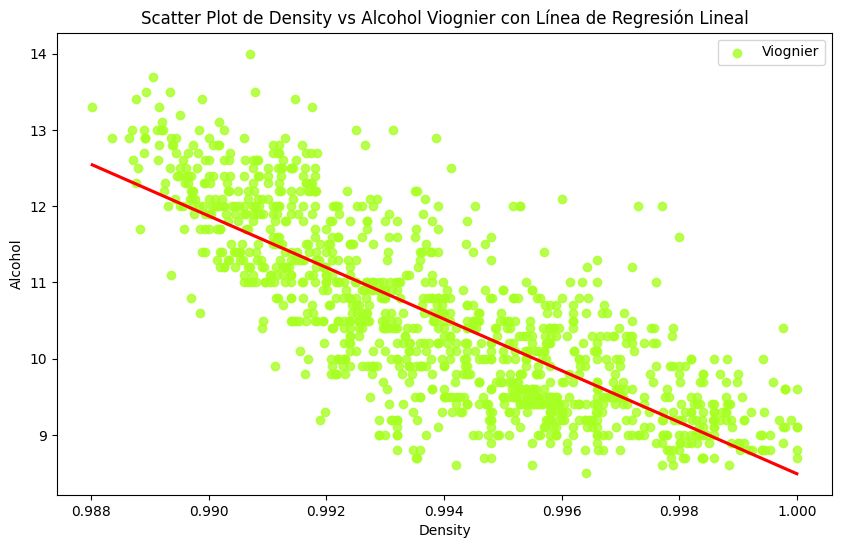

In [593]:
plt.figure(figsize=(10, 6))
sns.regplot(data=dataSet_viognier, x='density', y='alcohol', color='#a8FF23', line_kws={"color": "red"}, label='Viognier', ci=None) 
plt.title("Scatter Plot de Density vs Alcohol Viognier con Línea de Regresión Lineal")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.legend()
plt.show()

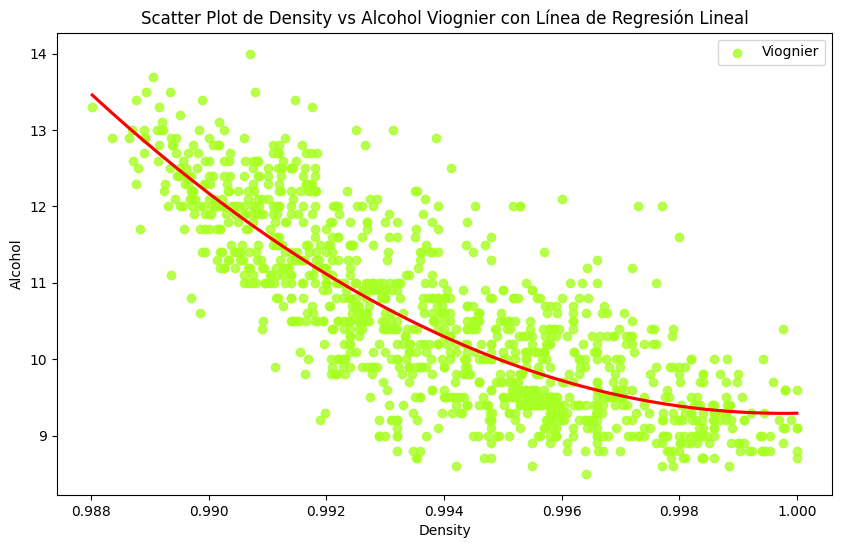

In [594]:
plt.figure(figsize=(10, 6))
sns.regplot(data=dataSet_viognier, x='density', y='alcohol', color='#a8FF23',order= 2, line_kws={"color": "red"}, label='Viognier', ci=None) 
plt.title("Scatter Plot de Density vs Alcohol Viognier con Línea de Regresión Lineal")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.legend()
plt.show()

#### Matriz de correlacion de Merlot

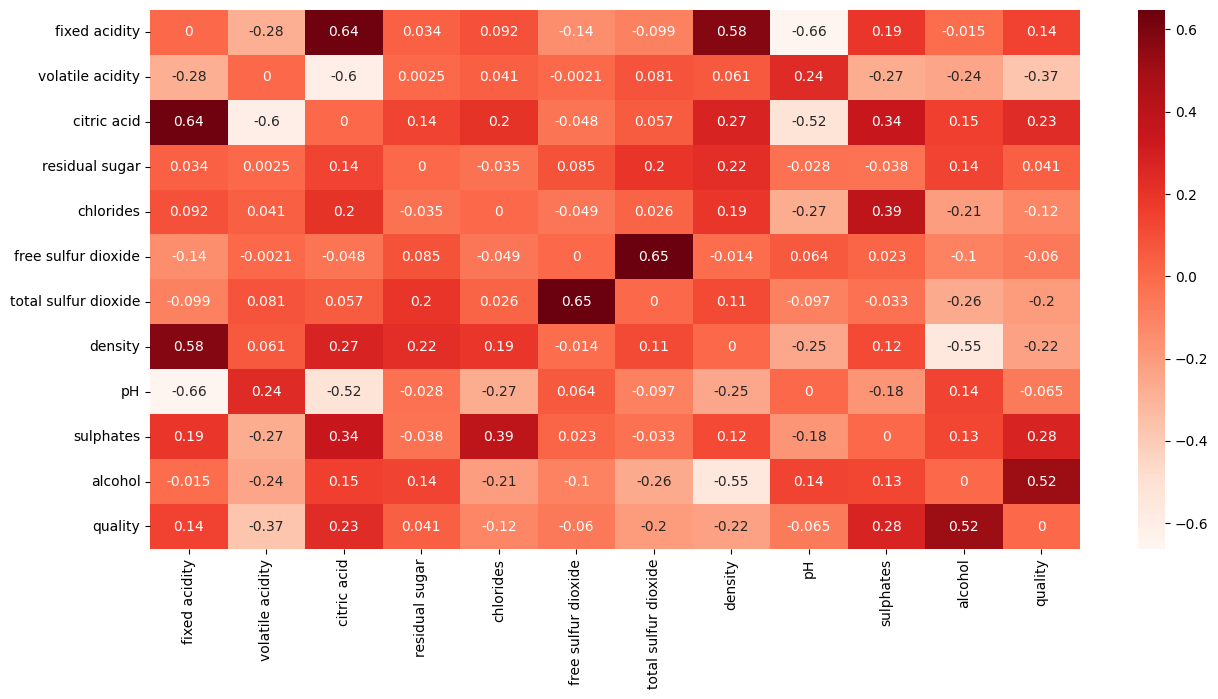

In [595]:
matrix_merlot = dataSet_merlot
matrix_merlot = matrix_merlot.corr()

np.fill_diagonal(matrix_merlot.values, 0)
plt.figure(figsize=(15,7))
sns.heatmap(matrix_merlot, center=0.0, annot=True, cmap='Reds')
plt.show()

Relaciones interesantes:
- Citric acid y Fixed acidity
- pH y Fixed acidity

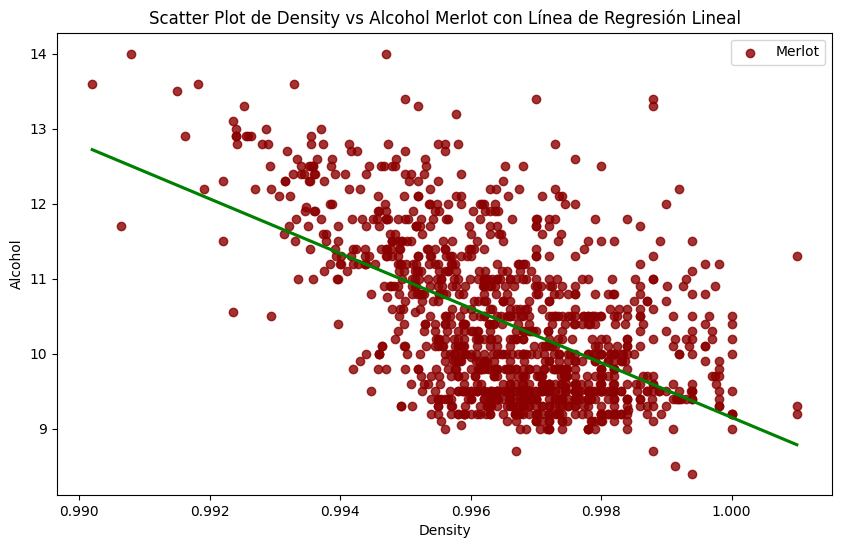

In [596]:
plt.figure(figsize=(10, 6))
sns.regplot(data=dataSet_merlot, x='density', y='alcohol', color='darkred', line_kws={"color": "green"}, label='Merlot', ci=None) 
plt.title("Scatter Plot de Density vs Alcohol Merlot con Línea de Regresión Lineal")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.legend()
plt.show()

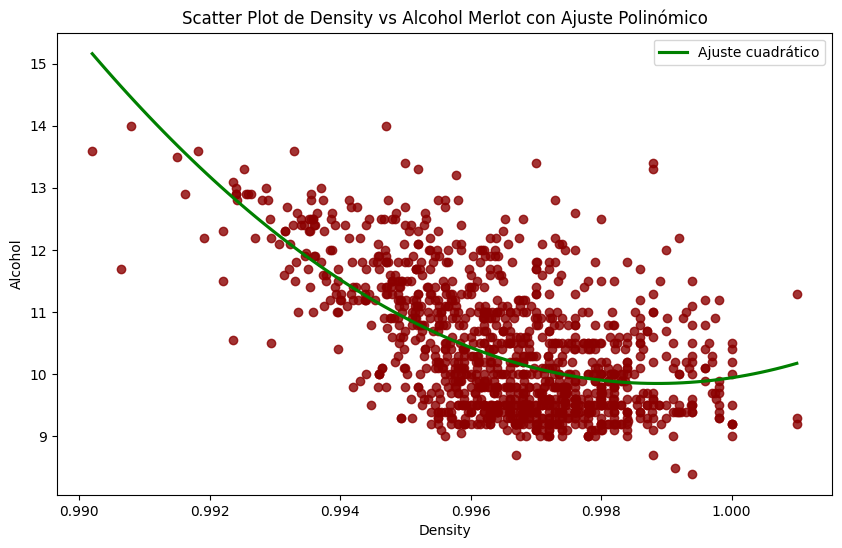

In [597]:
plt.figure(figsize=(10, 6))
#sns.scatterplot(data=dataSet_merlot, x='density', y='alcohol', color='darkred', label='Merlot')
sns.regplot(data=dataSet_merlot, x='density', y='alcohol', color='darkred', ci=None, order=2, line_kws={"color": "green","label": "Ajuste cuadrático"})  # Ajuste cuadrático
plt.title("Scatter Plot de Density vs Alcohol Merlot con Ajuste Polinómico")
plt.xlabel("Density")
plt.ylabel("Alcohol")
plt.legend()
plt.show()

### **Clusters**
Ahora vamos a normalizar los datos del dataset para poder trabajar con clusters

In [598]:
data_normalizada = dataSetCurado.copy()

numeric_cols = data_normalizada.drop(columns='quality').select_dtypes(include=np.number).columns

scaler = MinMaxScaler()

data_normalizada[numeric_cols] = scaler.fit_transform(data_normalizada[numeric_cols])

data_normalizada.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,Viognier,0.328767,0.100000,0.398374,0.311224,0.041736,0.181818,0.350168,0.445300,0.471264,0.115108,0.464286,7
1,Viognier,0.342466,0.044444,0.601626,0.051020,0.038397,0.259740,0.404040,0.406780,0.540230,0.165468,0.321429,6
2,Viognier,0.383562,0.433333,0.398374,0.326531,0.051753,0.363636,0.481481,0.553159,0.482759,0.079137,0.285714,5
3,Viognier,0.424658,0.022222,0.398374,0.030612,0.050083,0.545455,0.518519,0.414484,0.390805,0.187050,0.232143,6
4,Viognier,0.356164,0.411111,0.398374,0.632653,0.378965,0.532468,0.720539,0.830508,0.195402,0.208633,0.142857,5


Hacemos Elbow plot para buscar un valor de K optimo

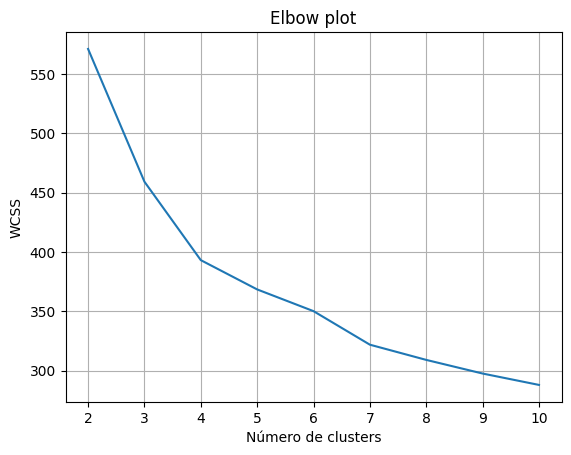

In [599]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(data_normalizada.drop(columns=['type','quality']))
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 11), wcss)
plt.title('Elbow plot')
plt.grid("True")
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Vemos que un K = 4 puede ser una buena opcion

Utilizamos el algoritmo KMeans, ya que la gran mayoria de las variables son cuantitativas continuas

In [600]:
calidad = data_normalizada['quality']
data_cluster_features = data_normalizada.drop(columns=['quality','type']).copy()

kmeans = KMeans(n_clusters=4, verbose=0, random_state=10)

kmeans.fit(data_cluster_features)

clusters_kmeans = kmeans.predict(data_cluster_features)
print(clusters_kmeans)

[1 1 2 ... 3 3 1]


Crear el DataFrame de los clusters

In [601]:
cluster_df = pd.DataFrame({'Calidad': calidad, 'Cluster': clusters_kmeans})

for cluster_num in range(4):
  print(f"\nCluster {cluster_num}:")
  print(cluster_df[cluster_df['Cluster'] == cluster_num]['Calidad'].tolist())


Cluster 0:
[4, 6, 5, 5, 5, 6, 4, 5, 6, 4, 6, 7, 5, 6, 6, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 6, 7, 5, 7, 6, 6, 6, 5, 6, 6, 5, 5, 5, 7, 7, 8, 6, 5, 8, 7, 6, 7, 6, 5, 5, 6, 5, 6, 5, 6, 6, 6, 6, 5, 7, 6, 7, 5, 5, 6, 7, 6, 6, 6, 6, 6, 7, 7, 6, 5, 6, 5, 5, 7, 6, 6, 7, 6, 6, 6, 7, 5, 5, 6, 6, 6, 6, 6, 7, 6, 6, 5, 7, 6, 6, 7, 7, 5, 6, 6, 6, 6, 7, 5, 6, 6, 7, 8, 5, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 5, 5, 6, 8, 5, 5, 6, 5, 6, 6, 7, 7, 8, 7, 7, 7, 7, 7, 6, 6, 6, 7, 5, 3, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 4, 6, 6, 4, 5, 5, 6, 5, 7, 7, 7, 5, 6, 7, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 6, 5, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 4, 6, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 6, 6, 5, 5, 7, 6, 7, 7, 5, 6, 6, 7, 3, 4, 7, 7, 6, 6, 5, 5, 6, 7, 7, 7, 7, 7, 6, 7, 6, 7, 5, 6, 6, 6, 7, 6, 6, 5, 5, 7, 6, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 6, 6, 6, 6, 6, 7, 6, 6, 7, 5, 7, 5, 6, 7, 6, 5, 7, 7, 7, 7, 5, 7, 6, 6, 7, 6, 6, 7, 7, 6, 7, 6, 6, 5, 7, 7, 7, 6, 8, 6, 6, 

Reducimos la dimensionalidad de los datos usando t-SNE

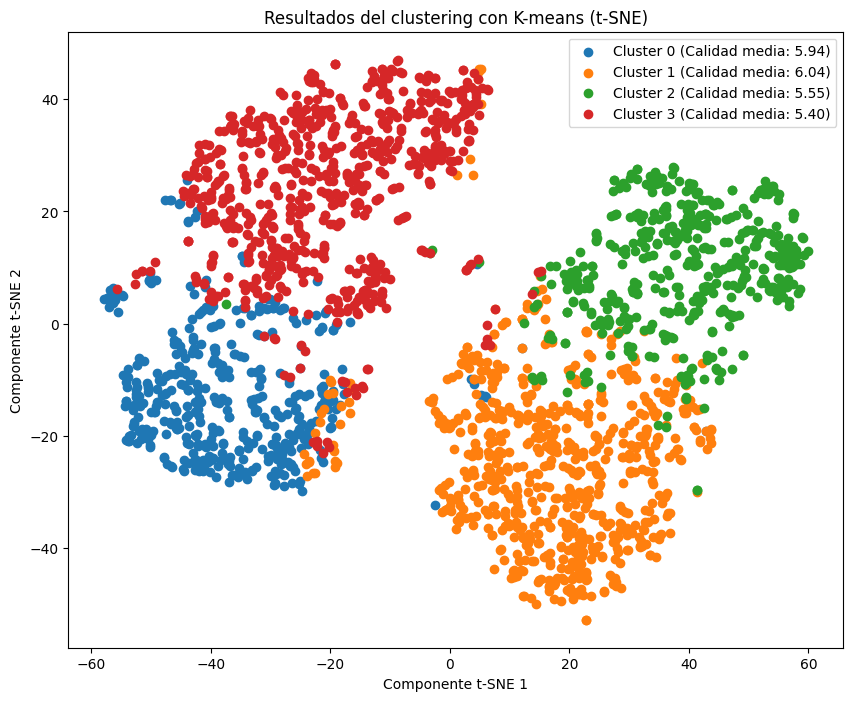

In [602]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_cluster_features)

tsne_df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'Cluster': clusters_kmeans, 'Calidad': calidad})

quality_avg_per_cluster = cluster_df.groupby('Cluster')['Calidad'].mean()

plt.figure(figsize=(10, 8))
for cluster_num in range(4):
    calidad_media = quality_avg_per_cluster[cluster_num]
    plt.scatter(tsne_df[tsne_df['Cluster'] == cluster_num]['x'], 
                tsne_df[tsne_df['Cluster'] == cluster_num]['y'], 
                label=f'Cluster {cluster_num} (Calidad media: {calidad_media:.2f})')

plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Resultados del clustering con K-means (t-SNE)')
plt.legend()
plt.show()

Vamos a analizar si esos dos grupos estan separados por el tipo de uva

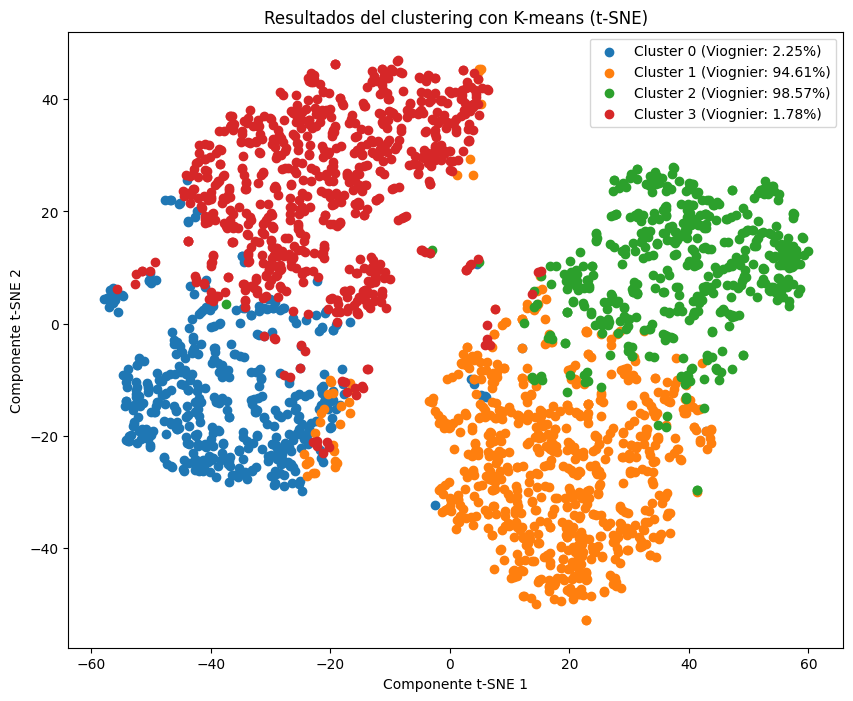

In [603]:
tipos_de_uva = data_normalizada['type']
data_cluster_features = data_normalizada.drop(columns=['quality', 'type']).copy()

kmeans = KMeans(n_clusters=4, verbose=0, random_state=10)
kmeans.fit(data_cluster_features)
clusters_kmeans = kmeans.predict(data_cluster_features)

cluster_df = pd.DataFrame({'tipo_de_uva': tipos_de_uva, 'Cluster': clusters_kmeans})

percentages = cluster_df.groupby(['Cluster', 'tipo_de_uva']).size().unstack(fill_value=0)
percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_cluster_features)
tsne_df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'Cluster': clusters_kmeans, 'tipo_de_uva': tipos_de_uva})

plt.figure(figsize=(10, 8))
for cluster_num in range(4):
    porcentaje_viognier = percentages.loc[cluster_num, 'Viognier'] if 'Viognier' in percentages.columns else 0
    plt.scatter(tsne_df[tsne_df['Cluster'] == cluster_num]['x'], 
                tsne_df[tsne_df['Cluster'] == cluster_num]['y'], 
                label=f'Cluster {cluster_num} (Viognier: {porcentaje_viognier:.2f}%)')

plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Resultados del clustering con K-means (t-SNE)')
plt.legend()
plt.show()

Los dos grupos que estan separados es por que uno es de uva merlot y el otro de viognier.

Vamos a evaluar los clusterings que construimos en función del Índice de Davies Bouldin y el Coeficiente de silueta 

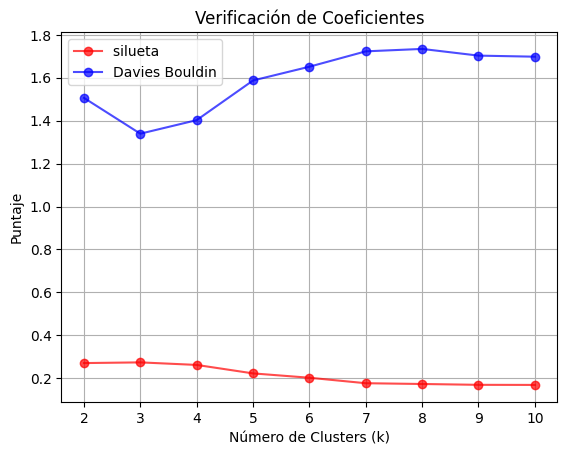

In [604]:
silhouette = []
davies_bouldin = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_cluster_features)
    silhouette.append(silhouette_score(data_cluster_features, clusters))
    davies_bouldin.append(davies_bouldin_score(data_cluster_features, clusters))

plt.plot(K, silhouette, '-ro', label='silueta ', alpha=0.7)
plt.plot(K, davies_bouldin, '-bo', label='Davies Bouldin', alpha=0.7)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje')
plt.title('Verificación de Coeficientes')
plt.legend()
plt.grid(True)
plt.show()

Los datos pueden no tener una estructura de clustering fuerte: Es posible que los datos no se presten bien a una agrupación mediante K-means, o que no haya clusters claramente definidos en el espacio de características.

Analizamos la media y la desviacion estandar graficando las medias con barras de error representando la desviación estándar


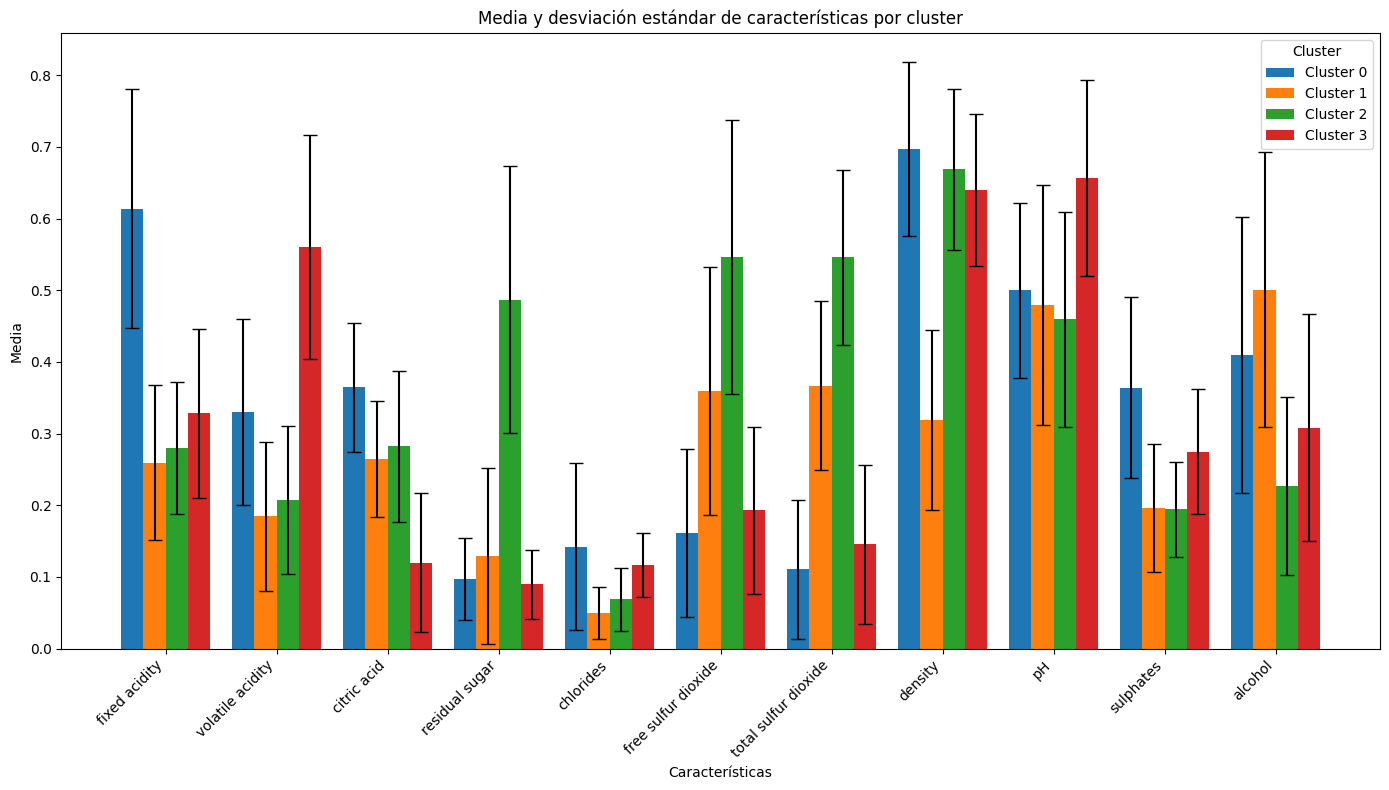

In [605]:
data_cluster_features['Cluster'] = clusters_kmeans 

cluster_stats = data_cluster_features.groupby('Cluster').mean()  
cluster_stats_std = data_cluster_features.groupby('Cluster').std() 

fig, ax = plt.subplots(figsize=(14, 8))


num_clusters = cluster_stats.shape[0]
bar_width = 0.2  


indices = range(len(cluster_stats.columns))

for i in range(num_clusters):
    means = cluster_stats.iloc[i]
    std_devs = cluster_stats_std.iloc[i]
    ax.bar([x + i * bar_width for x in indices], means, yerr=std_devs, width=bar_width, label=f'Cluster {i}', capsize=5)

ax.set_xticks([x + bar_width * (num_clusters - 1) / 2 for x in indices])
ax.set_xticklabels(cluster_stats.columns, rotation=45, ha='right')
ax.set_title("Media y desviación estándar de características por cluster")
ax.set_xlabel("Características")
ax.set_ylabel("Media")
ax.legend(title="Cluster")

plt.tight_layout()
plt.show()

- Interpretación de Clusters: Las diferencias en la media y la desviación estándar entre los clusters sugieren que cada grupo tiene perfiles característicos en algunas variables, pero también hay variabilidad interna significativa en ciertas características (donde la desviación estándar es alta).
- Importancia de la Desviación Estándar: La alta desviación estándar en características como volatile acidity y total sulfur dioxide en algunos clusters podría indicar que estas características no son determinantes para la clasificación o que se podrían explorar transformaciones o preprocesamientos adicionales para reducir la variabilidad.

### **Analisis de clusters segun el tipo de uva**

#### **Viognier**

Normalizamos los datos

In [606]:
dataSet_viognier_normalizado = dataSet_viognier.copy()
# Seleccionamos las columnas numéricas para la normalización
numeric_cols = dataSet_viognier_normalizado.drop(columns='quality').select_dtypes(include=np.number).columns

# Creamos un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustamos el scaler a los datos y transformamos los datos
dataSet_viognier_normalizado[numeric_cols] = scaler.fit_transform(dataSet_viognier_normalizado[numeric_cols])

# Imprimimos el DataFrame con los datos normalizados
dataSet_viognier_normalizado.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.600,0.125874,0.398374,0.311224,0.102881,0.160000,0.315603,0.482471,0.532468,0.190476,0.454545,7
1,0.625,0.055944,0.601626,0.051020,0.094650,0.240000,0.372340,0.440735,0.610390,0.273810,0.309091,6
2,0.700,0.545455,0.398374,0.326531,0.127572,0.346667,0.453901,0.599332,0.545455,0.130952,0.272727,5
3,0.775,0.027972,0.398374,0.030612,0.123457,0.533333,0.492908,0.449082,0.441558,0.309524,0.218182,6
4,0.650,0.517483,0.398374,0.632653,0.934156,0.520000,0.705674,0.899833,0.220779,0.345238,0.127273,5


Buscamos el mejor K

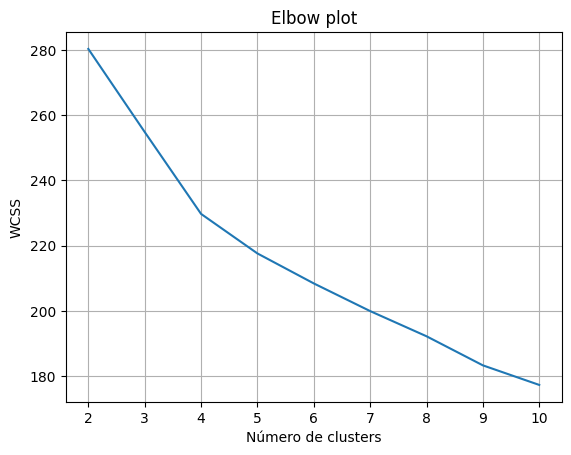

In [607]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(dataSet_viognier_normalizado.drop(columns='quality'))
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow plot')
plt.grid("True")
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Vemos que la una K = 4 puede ser la mejor opcion

Utilizampos el algoritmo de KMeans para encontrar clusters

In [608]:
calidad = dataSet_viognier_normalizado['quality']
dataset_para_cluster_viognier = dataSet_viognier_normalizado.drop(columns='quality').copy()

kmeans = KMeans(n_clusters=4, verbose=0, random_state=10)

kmeans.fit(dataset_para_cluster_viognier)

clusters_kmeans = kmeans.predict(dataset_para_cluster_viognier)
print(clusters_kmeans)

[0 2 2 ... 3 1 1]


In [609]:
# Crear el DataFrame de los clusters
cluster_df = pd.DataFrame({'Calidad': calidad, 'Cluster': clusters_kmeans})

# Imprimimos los países de cada cluster
for cluster_num in range(4):
  print(f"\nCluster {cluster_num}:")
  print(cluster_df[cluster_df['Cluster'] == cluster_num]['Calidad'].tolist())


Cluster 0:
[7, 5, 7, 7, 4, 5, 7, 5, 6, 7, 6, 5, 6, 6, 6, 6, 4, 6, 5, 7, 6, 7, 5, 7, 6, 7, 6, 5, 7, 7, 5, 6, 5, 5, 7, 7, 6, 6, 6, 5, 4, 5, 7, 5, 6, 6, 6, 7, 6, 7, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 7, 6, 4, 6, 6, 6, 6, 6, 6, 5, 6, 6, 7, 6, 5, 6, 7, 6, 6, 6, 5, 8, 6, 6, 7, 5, 3, 4, 6, 6, 6, 5, 7, 6, 5, 5, 6, 6, 5, 7, 5, 7, 6, 6, 6, 6, 6, 6, 7, 6, 8, 6, 7, 7, 6, 6, 6, 7, 5, 6, 7, 7, 5, 7, 6, 6, 6, 6, 6, 6, 7, 8, 8, 6, 6, 8, 7, 5, 5, 6, 7, 7, 5, 7, 5, 5, 7, 7, 6, 5, 4, 6, 5, 6, 4, 6, 7, 4, 5, 6, 7, 7, 5, 6, 6, 6, 7, 7, 6, 7, 7, 6, 6, 8, 6, 6, 5, 6, 5, 6, 8, 4, 8, 7, 5, 6, 6, 6, 7, 7, 6, 5, 6, 6, 5, 7, 5, 6, 6, 6, 7, 6, 6, 6, 8, 8, 8, 4, 6, 4, 8, 6, 6, 7, 6, 7, 6, 6, 5, 5, 6, 6, 5, 6, 8]

Cluster 1:
[8, 7, 6, 6, 6, 6, 6, 8, 5, 7, 6, 7, 8, 7, 7, 5, 6, 6, 6, 7, 6, 6, 7, 7, 6, 6, 5, 7, 7, 6, 7, 6, 5, 6, 7, 6, 4, 6, 5, 7, 6, 6, 4, 7, 6, 7, 6, 7, 7, 8, 7, 7, 7, 7, 6, 7, 8, 7, 6, 4, 6, 6, 6, 8, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 6, 6, 7, 7, 7, 5, 6, 7, 7, 6, 7, 7, 6, 5, 7, 5, 6, 7, 6, 7, 6, 6, 7, 7, 7, 7,

Reducimos la dimencionalidad para graficar

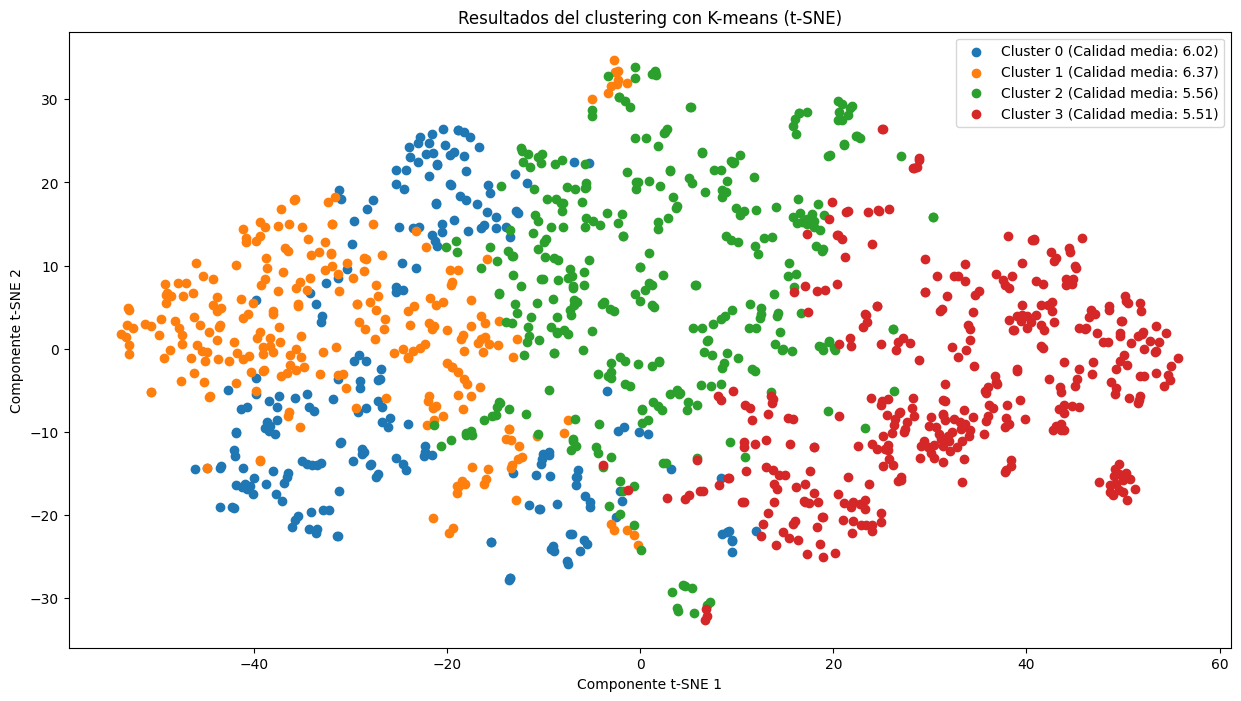

In [610]:
# Reducir la dimensionalidad de los datos usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(dataset_para_cluster_viognier)

# Crear un DataFrame con los resultados de t-SNE y los clusters
tsne_df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'Cluster': clusters_kmeans, 'Calidad': calidad})

quality_avg_per_cluster = cluster_df.groupby('Cluster')['Calidad'].mean()

# Graficar los resultados de t-SNE, coloreando los puntos según el cluster
plt.figure(figsize=(15, 8))
for cluster_num in range(4):
    calidad_media = quality_avg_per_cluster[cluster_num]
    plt.scatter(tsne_df[tsne_df['Cluster'] == cluster_num]['x'], 
                tsne_df[tsne_df['Cluster'] == cluster_num]['y'], 
                label=f'Cluster {cluster_num} (Calidad media: {calidad_media:.2f})')

plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Resultados del clustering con K-means (t-SNE)')
plt.legend()
plt.show()

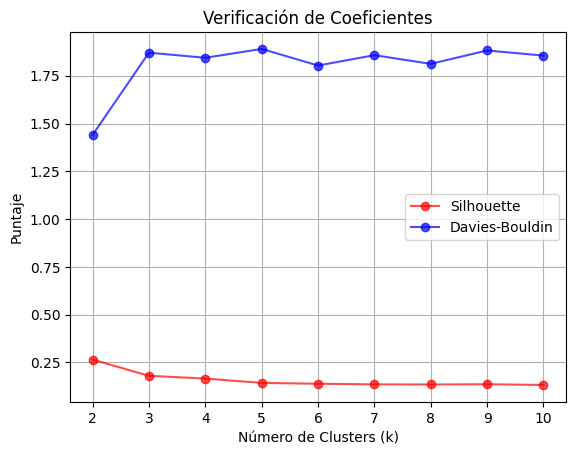

In [611]:
silhouette = []
davies_bouldin = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(dataset_para_cluster_viognier)
    silhouette.append(silhouette_score(dataset_para_cluster_viognier, clusters))
    davies_bouldin.append(davies_bouldin_score(dataset_para_cluster_viognier, clusters))

plt.plot(K, silhouette, '-ro', label='Silhouette', alpha=0.7)
plt.plot(K, davies_bouldin, '-bo', label='Davies-Bouldin', alpha=0.7)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje')
plt.title('Verificación de Coeficientes')
plt.legend()
plt.grid(True)
plt.show()

#### **Merlot**

Normalizamos los datos

In [612]:
dataSet_merlot_normalizado = dataSet_merlot.copy()
# Seleccionamos las columnas numéricas para la normalización
numeric_cols = dataSet_merlot_normalizado.drop(columns='quality').select_dtypes(include=np.number).columns

# Creamos un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustamos el scaler a los datos y transformamos los datos
dataSet_merlot_normalizado[numeric_cols] = scaler.fit_transform(dataSet_merlot_normalizado[numeric_cols])

# Imprimimos el DataFrame con los datos normalizados
dataSet_merlot_normalizado.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1190,0.328767,0.659091,0.000000,0.055118,0.106845,0.243902,0.098940,0.703704,0.779412,0.179688,0.178571,5
1191,0.383562,0.863636,0.000000,0.110236,0.143573,0.585366,0.215548,0.611111,0.323529,0.273438,0.250000,5
1192,0.383562,0.727273,0.051282,0.086614,0.133556,0.341463,0.169611,0.629630,0.411765,0.250000,0.250000,5
1193,0.849315,0.181818,0.717949,0.055118,0.105175,0.390244,0.190813,0.722222,0.264706,0.195312,0.250000,6
1194,0.328767,0.613636,0.000000,0.047244,0.105175,0.292683,0.120141,0.703704,0.779412,0.179688,0.178571,5


Buscamos el mejor K

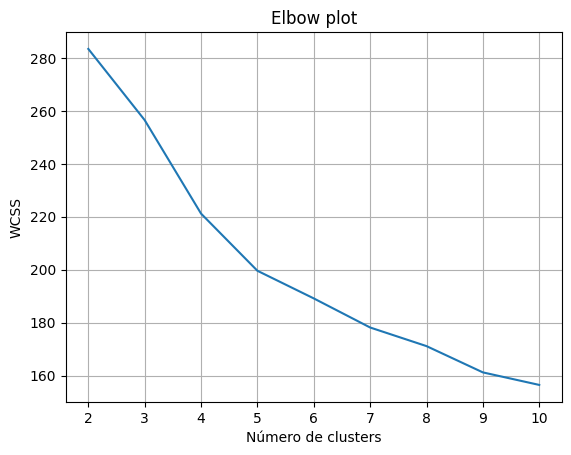

In [613]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(dataSet_merlot_normalizado.drop(columns='quality'))
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('Elbow plot')
plt.grid("True")
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Vemos que la una K = 4 puede ser la mejor opcion

Utilizampos el algoritmo de KMeans para encontrar clusters

In [614]:
calidad = dataSet_merlot_normalizado['quality']
dataset_para_cluster_merlot = dataSet_merlot_normalizado.drop(columns='quality').copy()

kmeans = KMeans(n_clusters=4, verbose=0, random_state=10)

kmeans.fit(dataset_para_cluster_merlot)

clusters_kmeans = kmeans.predict(dataset_para_cluster_merlot)
print(clusters_kmeans)

[3 3 3 ... 0 3 1]


In [615]:
# Crear el DataFrame de los clusters
cluster_df = pd.DataFrame({'Calidad': calidad, 'Cluster': clusters_kmeans})

# Imprimimos los países de cada cluster
for cluster_num in range(4):
  print(f"\nCluster {cluster_num}:")
  print(cluster_df[cluster_df['Cluster'] == cluster_num]['Calidad'].tolist())


Cluster 0:
[5, 7, 6, 5, 5, 6, 7, 4, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 4, 6, 6, 6, 5, 5, 5, 6, 5, 6, 7, 5, 6, 6, 5, 5, 5, 6, 7, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 6, 6, 5, 5, 5, 7, 5, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 8, 3, 4, 5, 7, 6, 5, 6, 5, 4, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 7, 7, 6, 6, 5, 8, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 7, 5, 6, 6, 5, 7, 5, 5, 6, 5, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 6]

Cluster 1:
[5, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 5, 6, 7, 7, 6, 6, 6, 7, 6, 5, 6, 7, 5, 6,

Reducimos la dimencionalidad para graficar

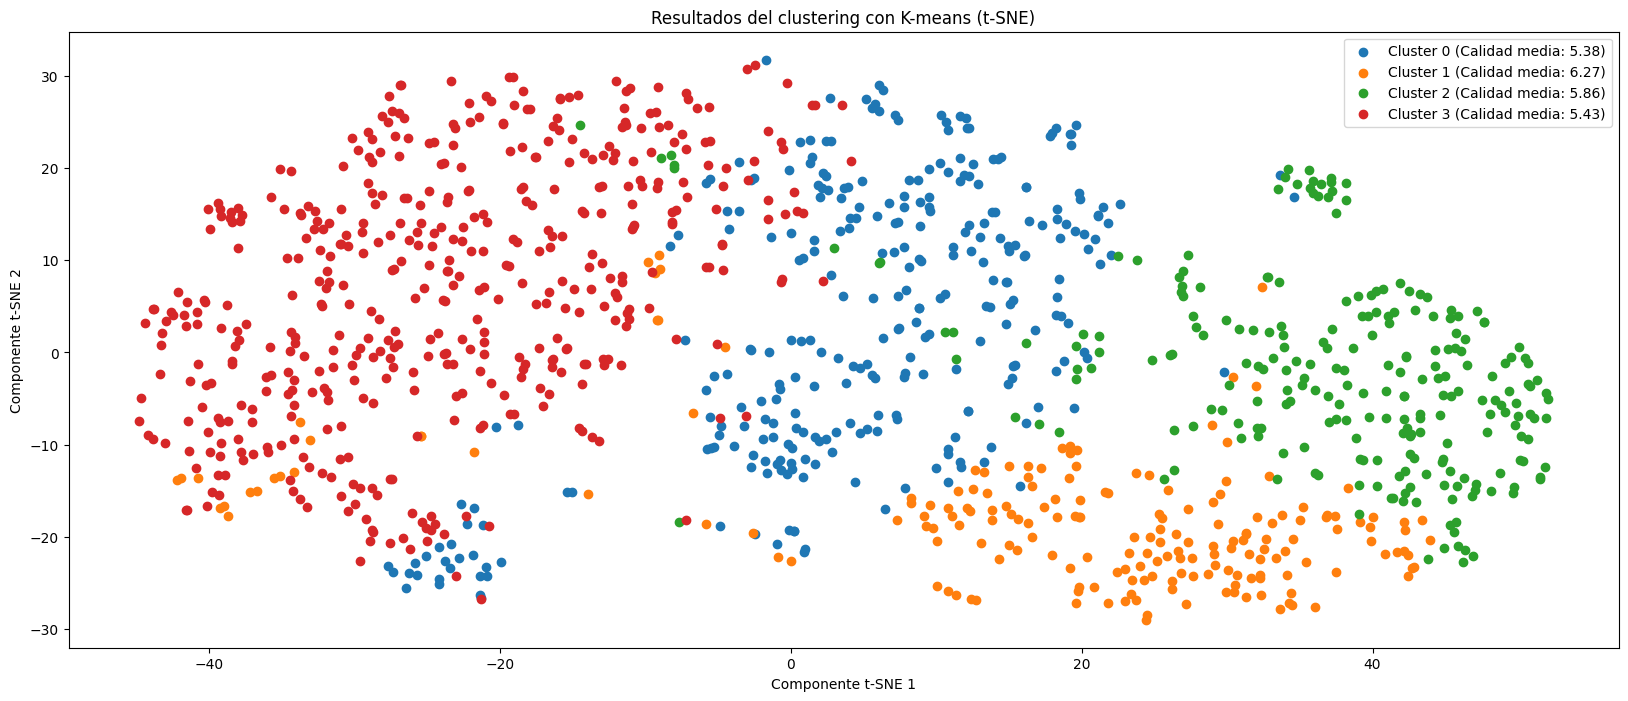

In [616]:
# Reducir la dimensionalidad de los datos usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(dataset_para_cluster_merlot)

# Crear un DataFrame con los resultados de t-SNE y los clusters
tsne_df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'Cluster': clusters_kmeans, 'Calidad': calidad})

quality_avg_per_cluster = cluster_df.groupby('Cluster')['Calidad'].mean()

# Graficar los resultados de t-SNE, coloreando los puntos según el cluster
plt.figure(figsize=(20, 8))
for cluster_num in range(4):
    calidad_media = quality_avg_per_cluster[cluster_num]
    plt.scatter(tsne_df[tsne_df['Cluster'] == cluster_num]['x'], 
                tsne_df[tsne_df['Cluster'] == cluster_num]['y'], 
                label=f'Cluster {cluster_num} (Calidad media: {calidad_media:.2f})')

plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Resultados del clustering con K-means (t-SNE)')
plt.legend(loc='upper right')
plt.show()

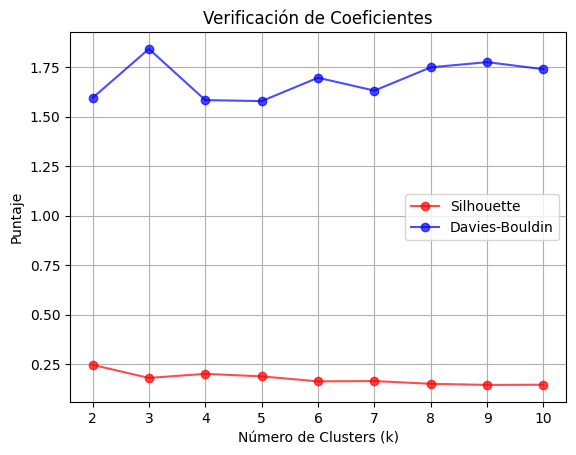

In [617]:
silhouette = []
davies_bouldin = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(dataset_para_cluster_merlot)
    silhouette.append(silhouette_score(dataset_para_cluster_merlot, clusters))
    davies_bouldin.append(davies_bouldin_score(dataset_para_cluster_merlot, clusters))

plt.plot(K, silhouette, '-ro', label='Silhouette', alpha=0.7)
plt.plot(K, davies_bouldin, '-bo', label='Davies-Bouldin', alpha=0.7)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje')
plt.title('Verificación de Coeficientes')
plt.legend()
plt.grid(True)
plt.show()

# **Planteamiento de hipotesis**

**Introduccion**


La Bodega afirma que sus clientes compran vinos basados en su puntuacion. Por ende, nos plantearon una inversion que tienen pensada hacer en la mejora de la calidad de sus vinos con el fin de que tengan una mejor puntuacion como estregia de conseguir nuevos clientes. Es asi como nos encargaron analizar la relacion de la calidad de un vino con los diversos atributos que lo caracterizan. Es por esta razon que nuestro analisis se centrara en la variable `quality` que indica la puntuacion de cada vino y algunas variables de interes para la Bodega.

**Hagamos un analisis de correlacion de la variable quality con las distintas variables del dataset**


*   Comenzemos por hacer un heat map usando el metodo de correlacion de spearman




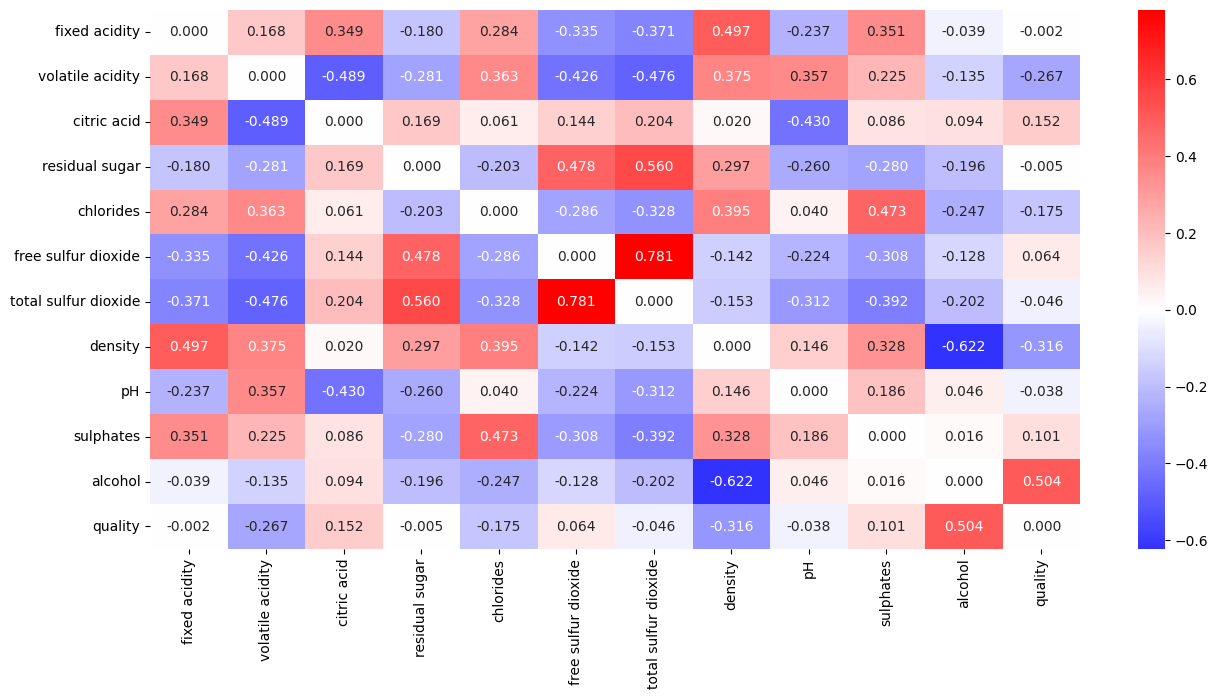

In [618]:
matrix = dataSetCurado.drop(["type"], axis=1)
matrix = matrix.corr()
np.fill_diagonal(matrix.values, 0)
plt.figure(figsize=(15,7))
sns.heatmap(matrix, center=0.0, annot=True, cmap='bwr',fmt='.3f' )
plt.show()

Sigamos por hacer un analisis usando PCA

In [619]:
#repasamos las variables del dataset para ver si tenemos alguna variable dicotomica que sacar
dataSetCurado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  2389 non-null   string 
 1   fixed acidity         2389 non-null   float64
 2   volatile acidity      2389 non-null   float64
 3   citric acid           2389 non-null   float64
 4   residual sugar        2389 non-null   float64
 5   chlorides             2389 non-null   float64
 6   free sulfur dioxide   2389 non-null   float64
 7   total sulfur dioxide  2389 non-null   float64
 8   density               2389 non-null   float64
 9   pH                    2389 non-null   float64
 10  sulphates             2389 non-null   float64
 11  alcohol               2389 non-null   float64
 12  quality               2389 non-null   int64  
dtypes: float64(11), int64(1), string(1)
memory usage: 242.8 KB


Vemos que existe una variable dicotomica que es la variable `type`. Por ende, para este analisis usando PCA sacaremos del dataset la variable `type` y `quality` que es la variable que queremos estudiar en relación a las demas.

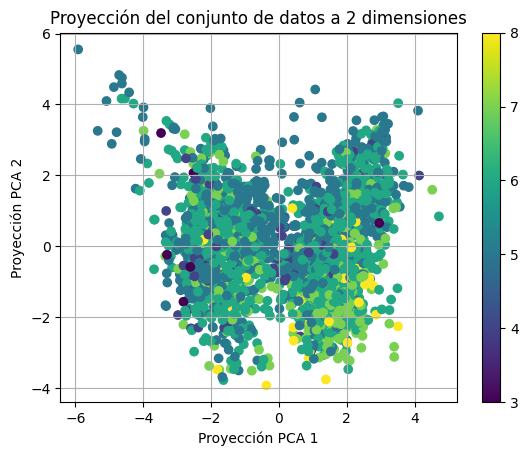

In [620]:
dataSetPCA = dataSetCurado.copy()
#quitamos al variable quality
dataSetPCA = dataSetPCA.drop(['quality','type'], axis=1)

#estandarizamos el dataset
scaler = StandardScaler()
dataSetPCA_scaled = scaler.fit_transform(dataSetPCA)

# declaramos un objeto PCA que mapee a 2 dimensiones.
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(dataSetPCA_scaled)

# graficamos los datos. el color de cada punto representa el valor de la casa
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= dataSetCurado['quality'], cmap='viridis')
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()

## **Primera hipotesis**




* La bodega tiene tan solo 2 tipos de uva con la que hacen vinos.
Nos preguntamos ¿cual sera la uva que obtiene mejores puntuaciones?

**HIPOTESIS 1**



*   Los vinos elaborados con el tipo de uva Merlot tienen una puntuación promedio igual a la de los vinos elaborados con el tipo de uva Viognier




### **Analisis grafico**

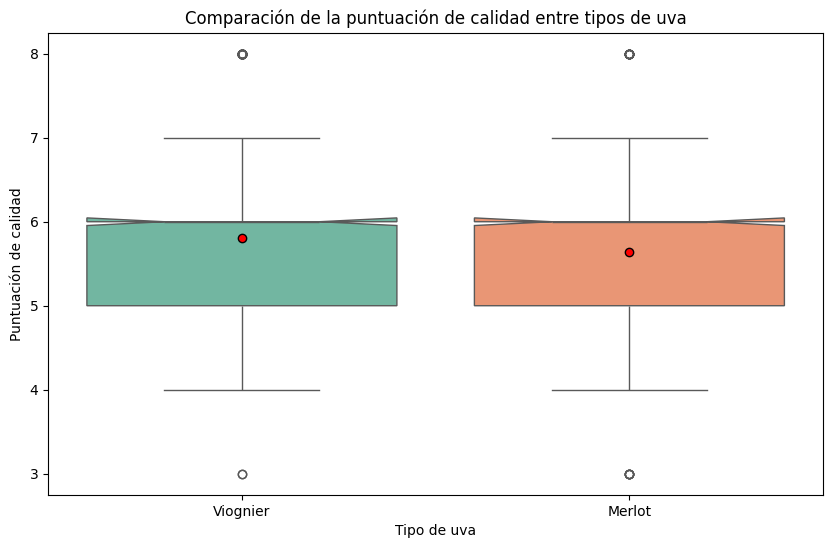

In [621]:
# Crear el boxplot comparando la calidad ('quality') entre los tipos de uva ('type')
plt.figure(figsize=(10, 6))                                       #add de media y colores, el hue y el legend van para que no salga el warning feo
sns.boxplot(x='type', y='quality', data=dataSetCurado, notch=True, showmeans=True,hue='type',legend = False, palette='Set2', meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black'})
#Si en la variable type hubiera 4 categorías distintas, cada una tendría su propio boxplot en el gráfico generado
# Añadir etiquetas y título
plt.xlabel('Tipo de uva')
plt.ylabel('Puntuación de calidad')
#plt.xticks(ticks=[0, 1], labels=["Viognier", "Merlot"]) -- esto no va prq lo que hace es reemplzar los valores 0 por viognier y 1 por merlot
plt.title('Comparación de la puntuación de calidad entre tipos de uva')

# Mostrar el gráfico
plt.show()

Son muestras independientes?

Aunque todos los vinos provienen de la misma bodega, las características de los vinos (como el tipo de uva) hacen que los grupos sean conceptualmente diferentes. Los datos de un grupo (tipo de uva Merlot) no afectan los datos del otro grupo (tipo de uva Viogner), y no hay correspondencia uno a uno entre las muestras de los dos grupos.

### **Validamos homocedasticidad**

Separamos los datos en dos grupos por tipo de uva

In [622]:
merlotQuality = dataSetCurado[dataSetCurado['type'] == "Merlot"]['quality']
viognierQuality = dataSetCurado[dataSetCurado['type'] == "Viognier"]['quality']

In [623]:
stat, p = stats.levene(viognierQuality, merlotQuality)
print(f"Test de Levene para type: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para type: Estadístico=0.466, p-valor=0.495


obtuvimos un p-valor mayor a 0.05, por ende se cumple la homocedasticidad

### **Eleccion de test y validacion de hipotesis**

Como nuestro conjunto no cumple normalidad pero sí homocedasticidad, podemos recurrir al test de Mann Whitney U para evaluar la significancia estadística de las diferencias entre ambos grupos.La hipótesis nula del test es que no existen diferencias significativas entre los dos grupos provistos. Por consiguiente, si el p-valor del test nos da por debajo del umbral de significancia, efectivamente hay una diferencia significativa entre ambos.

In [624]:
# Test de Mann-Whitney U para comparar las puntuaciones de calidad de vino entre los vinos Merlot y en Viogner
stat, p = stats.mannwhitneyu(viognierQuality, merlotQuality)
print(f"Test de Mann-Whitney U para quality: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    #print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en la puntuacion de calidad entre vinos")
else:
    #print("Se rechaza la hipótesis nula.")
    print("Hay una diferencia significativa en la puntuacion de calidad entre vinos")

Test de Mann-Whitney U para quality: Estadístico=789602.000, p-valor=0.000
Hay una diferencia significativa en la puntuacion de calidad entre vinos


Por ende, rechazamos la hipotesis nula y concluimos que hay diferencia entre la puntacion promedio de los vinos Merlot y Viogner

## **Segunda hipotesis**


**HIPOTESIS 2**

Los vinos de la bodega con un nivel de alcohol superior al promedio tienen una puntuación mayor a los vinos con un nivel de alcohol menor a este umbral.

### **Analisis grafico**

Creamos el boxplot comparando la calidad ('quality') entre los intervalos mayores al valor umbral de alcohol

La media de alcohol es: 10.46


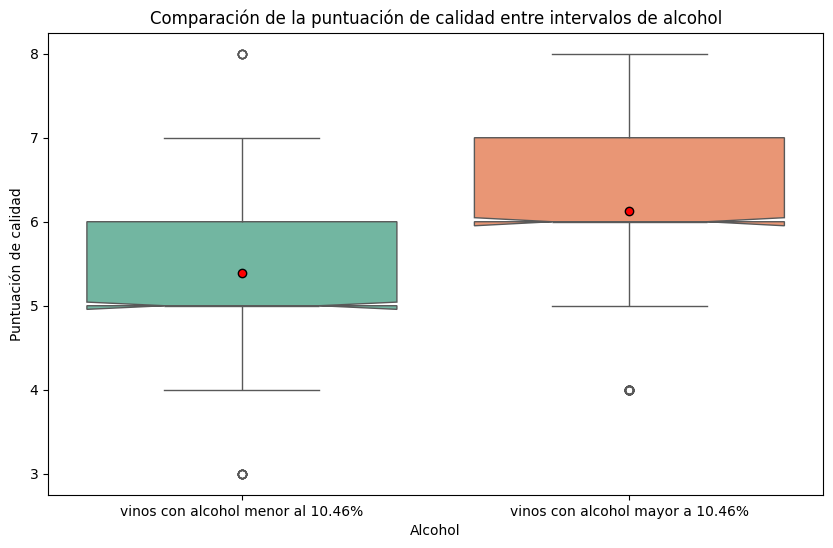

In [625]:
#calculo de la media de la variable alcohol
alcohol_mean = dataSetCurado['alcohol'].mean()
print(f"La media de alcohol es: {alcohol_mean:.2f}")

dataSetCurado['alcohol_interval'] = pd.cut(dataSetCurado['alcohol'],
                                          bins=[0, alcohol_mean, float('inf')],
                                          labels=[f'<= {alcohol_mean:.2f}%', f'> {alcohol_mean:.2f}%'])
"""
    pd.cut se usa para dividir los valores de la columna 'alcohol' en intervalos (bins).
    bins=[0, media de alcohol, float('inf')] define los intervalos: de 0 a media de alcohol (incluido) y del valor de la media de alcohol a infinito.
    labels=['<= alcohol_mean', '> alcohol_mean'] asigna etiquetas a los intervalos.
"""

plt.figure(figsize=(10, 6))
sns.boxplot(x='alcohol_interval', y='quality', data=dataSetCurado, notch=True, showmeans=True, hue='alcohol_interval', palette='Set2',legend=False, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black'})
plt.xlabel('Alcohol')
plt.ylabel('Puntuación de calidad')
plt.title('Comparación de la puntuación de calidad entre intervalos de alcohol')
plt.xticks(ticks=[f'<= {alcohol_mean:.2f}%',f'> {alcohol_mean:.2f}%'], labels=[f'vinos con alcohol menor al {alcohol_mean:.2f}%', f'vinos con alcohol mayor a {alcohol_mean:.2f}%'])
plt.show()

#quitamos la tabla por que no seguira siendo necesaria
dataSetCurado = dataSetCurado.drop('alcohol_interval', axis=1)

En un principio la hipotesis parece tener sentido de acuerdo a lo que nos muestra el grafico

### **Verificamos homocedasticidad**

Separamos los datos en dos grupos. uno con la quality de los vinos con alcohol mayor a la media y otro con menor o igual a la media.

In [626]:
vinos_alto_alcohol = dataSetCurado[dataSetCurado['alcohol'] > alcohol_mean]['quality']
vinos_bajo_alcohol = dataSetCurado[dataSetCurado['alcohol'] <= alcohol_mean]['quality']

Usaremos el test de Levene para comprobar la homocedastidad ya que es un test robusto para distribuciones que no son normales.


*  En Levene la hipótesis nula es que las varianzas son significativamente diferentes entre sí (hay heterocedasticidad)
*   Usaremos un nivel de significancia del 5% (buscamos p-valor mayor a 0.05)


In [627]:
stat, p = stats.levene(vinos_alto_alcohol, vinos_bajo_alcohol)
print(f"Test de Levene para alcohol: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para alcohol: Estadístico=14.196, p-valor=0.000


como el p-valor es menor a 0,05 rechazamos la hipotesis nula del test de levene y verificamos que no se cumple la homocedastidad de varianzas

### **Eleccion de test y validacion de hipotesis**



*   Como las muestras independientes no son normales, ni tampoco cumplen homocedasticidad usaremos un test de Kruskal-Wallis para verificar la hipotesis planteada


*   La hipótesis nula del test es que no existen diferencias significativas entre los dos grupos provistos. Por consiguiente, si el p-valor del test nos da por debajo del umbral de significancia (variable alpha = 0.05 controla esto), efectivamente hay una diferencia significativa entre ambos.





In [628]:
# Test de Mann-Whitney U para comparar las puntuaciones de calidad de vino entre los vinos Merlot y en Viogner
stat, p = stats.mannwhitneyu(vinos_alto_alcohol, vinos_bajo_alcohol)
print(f"Test de Mann-Whitney U para quality: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    #print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en la puntuacion de calidad entre vinos con alto y bajo porcentaje de alcohol")
else:
    #print("Se rechaza la hipótesis nula.")
    print("Hay una diferencia significativa en la puntuacion de calidad entre vinos con alto y bajo porcentaje de alcohol")

Test de Mann-Whitney U para quality: Estadístico=1045922.000, p-valor=0.000
Hay una diferencia significativa en la puntuacion de calidad entre vinos con alto y bajo porcentaje de alcohol


Ayudandonos con el grafico de boxplot en la seccion de analisis de la hipotesis podemos concluir que se acepta la hipotesis nula ya que probamos que existe una diferencia significativa entre la puntuacion de las muestras tomadas y en el grafico de boxplot vimos como a partir del Q1 la distribucion de los vinos con porcentaje de alcohol mayor a la media tenia mayor puntuacion que practicamente todos los vinos con porcentaje de alcohol menor o igual a la media.

Para estar seguros, haremos el test de Mann-Whitney a una sola cola.

tener en cuenta que la hipotesis nula es  que la distribución de la calidad de los vinos con alto alcohol es menor o igual que la distribución de la calidad de los vinos con bajo alcohol.

In [629]:
# Test de Mann-Whitney U a una cola (mayor)
stat, p = stats.mannwhitneyu(vinos_alto_alcohol, vinos_bajo_alcohol, alternative='greater')
print(f"Test de Mann-Whitney U a una cola (mayor): Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para afirmar que los vinos con alto alcohol tienen mayor calidad.")
else:
    print("Hay suficiente evidencia para afirmar que los vinos con alto alcohol tienen mayor calidad.")


Test de Mann-Whitney U a una cola (mayor): Estadístico=1045922.000, p-valor=0.000
Hay suficiente evidencia para afirmar que los vinos con alto alcohol tienen mayor calidad.


Luego de ver los resultados del test, se rechaza la hipotesis nula de que los vinos con mayor porcentaje de alcohol tienen menor o igual puntuacion que los vinos con menor porcentaje de alcohol.

## **Tercer Hipotesis**


**Hipotesis 3**

¿Mientas mayor sea la acidez en el vino menor puntuacion tendra?

*   Intentaremos testear la hipotesis de que los vinos con acidez mayor al promedio tienen menor puntuacion que aquellos con acidez menor al promedio.

Para el analisis de la hipotesis usaremos la variable ya conocida `quality` y la variable `pH` que nos indica la acidez del vino.


*   **Nota**: mientras mas chico sea el valor de `pH` mayor es la acidez




### **Analisis grafico**

Creamos el boxplot comparando la calidad ('quality') entre los intervalos mayores al valor umbral de pH

La media de pH es: 3.25


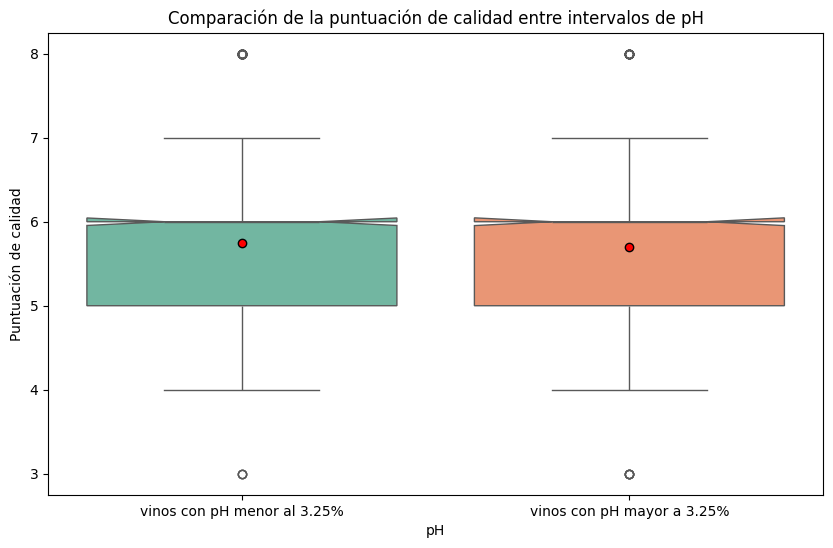

In [630]:
#calculo de la media de la variable pH
pH_mean = dataSetCurado['pH'].mean()
print(f"La media de pH es: {pH_mean:.2f}")

dataSetCurado['pH_interval'] = pd.cut(dataSetCurado['pH'],
                                          bins=[0, pH_mean, float('inf')],
                                          labels=[f'<= {pH_mean:.2f}%', f'> {pH_mean:.2f}%'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='pH_interval', y='quality', data=dataSetCurado, notch=True, showmeans=True, hue='pH_interval', palette='Set2',legend=False, meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black'})
plt.xlabel('pH')
plt.ylabel('Puntuación de calidad')
plt.title('Comparación de la puntuación de calidad entre intervalos de pH')
plt.xticks(ticks=[f'<= {pH_mean:.2f}%',f'> {pH_mean:.2f}%'], labels=[f'vinos con pH menor al {pH_mean:.2f}%', f'vinos con pH mayor a {pH_mean:.2f}%'])
plt.show()

#quitamos la tabla por que no seguira siendo necesaria
dataSetCurado = dataSetCurado.drop('pH_interval', axis=1)

### **Test de Homocedasticidad**

Como la distribucion de las muestras no es normal usaremos el test de Levene ya anteriormente utilizado para evaluar la homocedasticidad de las muestras

Separamos los datos en dos grupos segun el pH de los vinos

In [631]:
vinos_alto_pH = dataSetCurado[dataSetCurado['pH'] > pH_mean]['quality']
vinos_bajo_pH = dataSetCurado[dataSetCurado['pH'] <= pH_mean]['quality']

In [632]:
stat, p = stats.levene(vinos_alto_pH, vinos_bajo_pH)
print(f"Test de Levene para pH: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para pH: Estadístico=0.581, p-valor=0.446


Como el p-valor resulta mayor a 0,05 entonces se acepta la hipotesis nula del test y se valida la homocedasticidad de las muestras

### **Eleccion de test y validacion de hipotesis**

*   Como las muestras independientes no son normales, ni tampoco cumplen homocedasticidad usaremos un test de Kruskal-Wallis para verificar la hipotesis planteada


*   La hipótesis nula del test es que no existen diferencias significativas entre los dos grupos provistos. Por consiguiente, si el p-valor del test nos da por debajo del umbral de significancia (variable alpha = 0.05 controla esto), efectivamente hay una diferencia significativa entre ambos.


In [633]:
# Test de Mann-Whitney U para comparar el pH de los vinos
stat, p = stats.mannwhitneyu(vinos_alto_pH, vinos_bajo_pH)
print(f"Test de Mann-Whitney U para quality: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay una diferencia significativa en la calidad de los vinos con bajo y alto pH")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en  la calidad de los vinos con bajo y alto pH")

Test de Mann-Whitney U para quality: Estadístico=699135.000, p-valor=0.391
No hay suficiente evidencia para rechazar la hipótesis nula.
No hay una diferencia significativa en la calidad de los vinos con bajo y alto pH


Nos preguntabamos si mientas mayor sea la acidez en el vino menor puntuacion tendria. Bueno, el test nos dice que no hay diferencias significativas como para poder aceptar la hipotesis de que los vinos con acidez mayor al promedio tienen menor puntuacion que aquellos con acidez menor al promedio. Por ende, rechazamos la hipotesis propuesta.


## **Cuarta hipotesis**

**HIPOTESIS 4**

Los vinos de la bodega con un nivel de acido volatil alto tienen una puntuación de calidad baja

### Analisis de la hipotesis

Agregar una columna de calidad categórica para todos los datos y creamos un boxplot para cada variable cuantitativa en función de la categoría de calidad

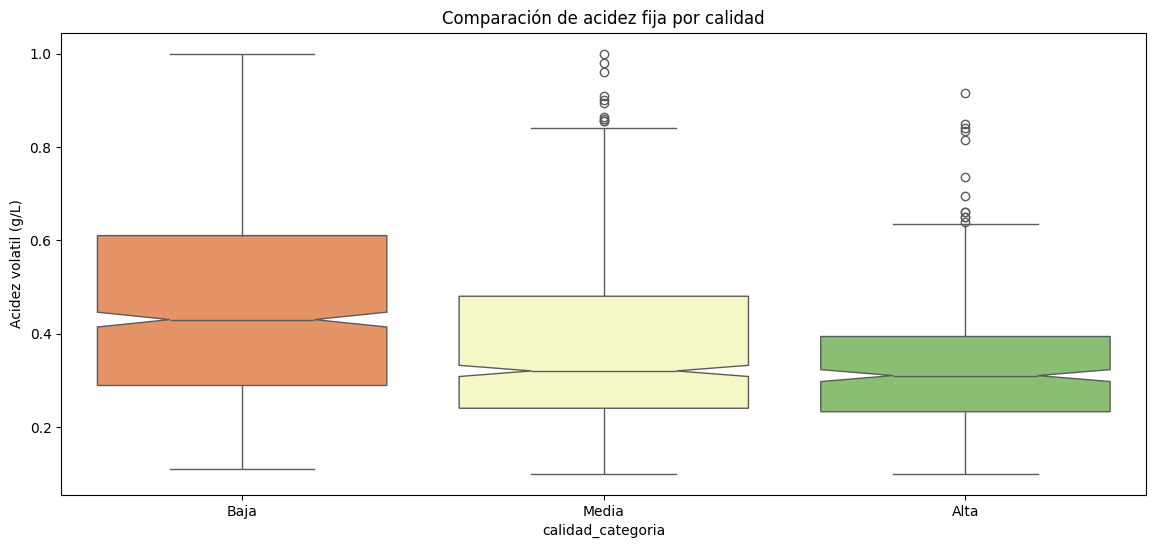

In [634]:
dataset_con_categoria = dataSetCurado.copy()
dataset_con_categoria['calidad_categoria'] = pd.qcut(dataset_con_categoria['quality'], q=3, labels=['Baja', 'Media', 'Alta'])

plt.figure(figsize=(14, 6))
sns.boxplot(x='calidad_categoria', y='volatile acidity', data=dataset_con_categoria, notch=True, palette= 'RdYlGn', hue='calidad_categoria')
plt.title("Comparación de acidez fija por calidad")
plt.ylabel('Acidez volatil (g/L)')
plt.show()

Podemos ver que existe una relacion entre la cantidad de Acidez volatil y la calidad de los vinos; esto se debe a que los vinos picados son aquellos que tiene una acidez volatil mayor a 1 g/l

### **Test de Homocedasticidad**

Vamos a dividir el dataset en 3 partes:
- calidad alta
- calidad baja
- calidad media

In [635]:
Q1 = dataSetCurado['volatile acidity'].quantile(0.25)
Q3 = dataSetCurado['volatile acidity'].quantile(0.75)

calidad_alta = dataSetCurado[dataSetCurado['volatile acidity'] >= Q3]['quality'].copy()
calidad_baja = dataSetCurado[dataSetCurado['volatile acidity'] <= Q1]['quality'].copy()
calidad_media = dataSetCurado[(dataSetCurado['volatile acidity'] < Q3) & (dataSetCurado['volatile acidity'] > Q1)]['quality'].copy()

In [636]:
stat, p = stats.levene(calidad_alta, calidad_baja, calidad_media)
print(f"Test de Levene para pH: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para pH: Estadístico=15.264, p-valor=0.000


Como el p-valor resulta menor a 0,05 entonces se rechaza la hipotesis nula del test y se valida que no hay homocedasticidad

### **Test de hipotesis**

Aplicar la prueba de Kruskal-Wallis para comparar la acidez volátil entre los grupos de calidad

In [637]:
kruskal_result = kruskal(calidad_alta, calidad_media, calidad_baja)

print(f"Estadistica de prueba: {kruskal_result.statistic:.3f}")
print(f"Valor p: {kruskal_result.pvalue:.3f}")

Estadistica de prueba: 160.517
Valor p: 0.000


Rechazo de la hipótesis nula:

Dado que el valor p es mucho menor que un nivel de significancia típico (por ejemplo, 0.05), puedes rechazar la hipótesis nula. Esto indica que hay diferencias estadísticamente significativas en la acidez volátil entre al menos uno de los grupos de calidad (alta, media y baja).

### **Analisis por puntiacion de calidad**

Ahora vamos a analizar por cada puntaje de calidad para ver si realmente la acidez volátil varía significativamente entre los distintos niveles de calidad de los vinos.

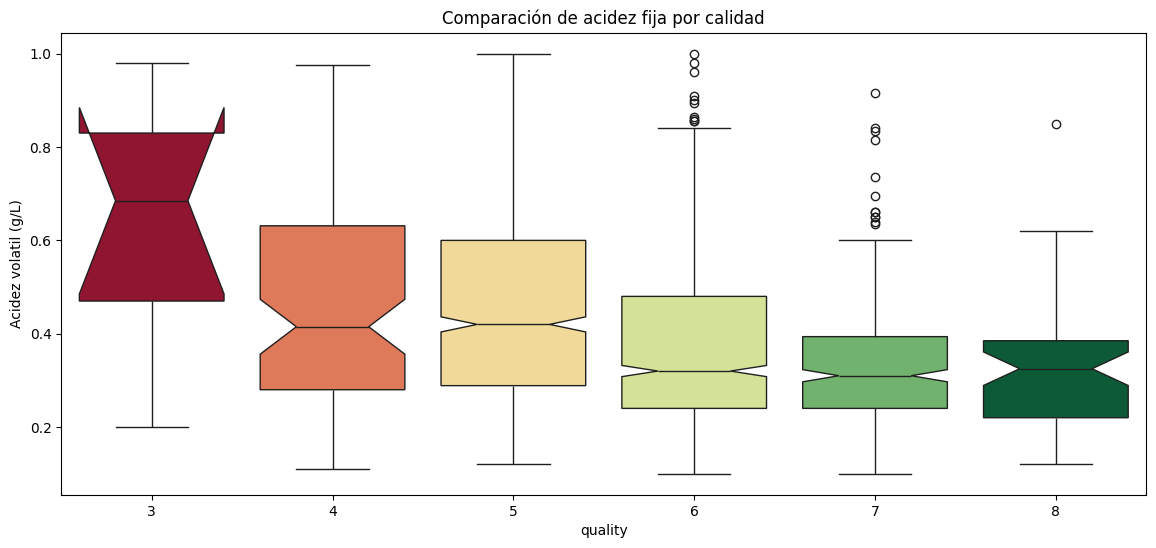

In [638]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='quality', y='volatile acidity', data=dataSetCurado, notch=True, palette= 'RdYlGn', hue='quality', legend=False)
plt.title("Comparación de acidez fija por calidad")
plt.ylabel('Acidez volatil (g/L)')
plt.show()

se rechaza la hipotesis nula por ende indica que la acidez volátil varía significativamente entre los distintos niveles de calidad de los vinos.

Analisis de otro dataset

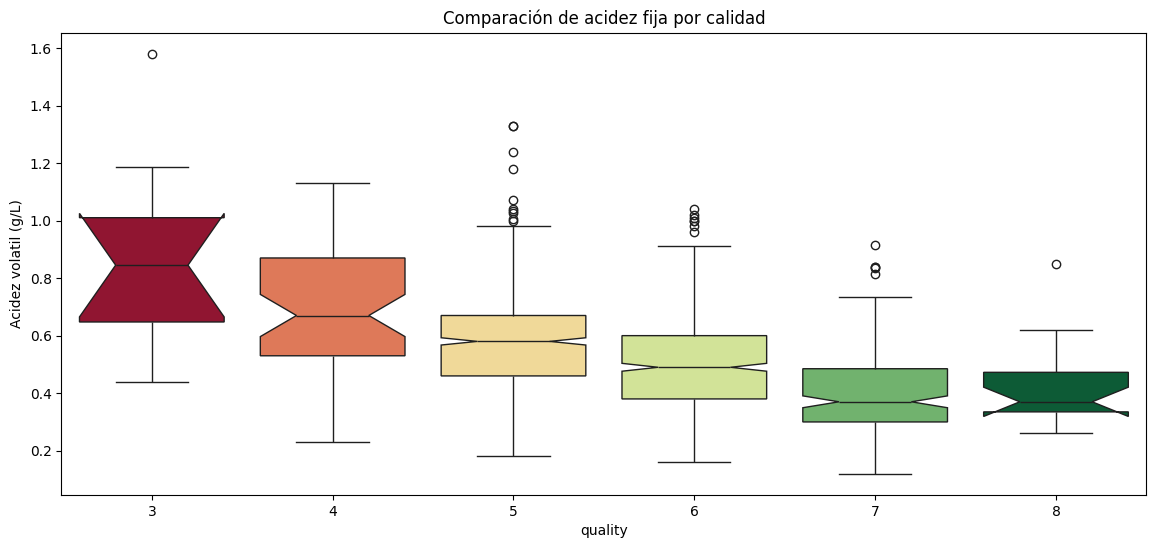

In [639]:
data1 = pd.read_csv('wine quality datasets/winequality-red.csv', delimiter=";")

plt.figure(figsize=(14, 6))
sns.boxplot(x='quality', y='volatile acidity', data=data1, notch=True, palette= 'RdYlGn', hue='quality', legend=False)
plt.title("Comparación de acidez fija por calidad")
plt.ylabel('Acidez volatil (g/L)')
plt.show()